# **Time Series Analysis of Walmart Sales Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# **1. Objective and Dataset**
Refer to the point 1 from Detailed Breakdown section on Teachable

In [ ]:
# =============================================================================
# WALMART WEEKLY SALES FORECASTING SYSTEM
# Phase 1: Environment Setup & Configuration
# =============================================================================

# 1. Standard Library & Data Processing
import pandas as pd
import numpy as np
import warnings
import itertools
from IPython.display import display

# 2. Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 3. Statistical Modeling & Machine Learning
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modeling Algorithms
from statsmodels.tsa.arima.model import ARIMA        # Baseline Time Series
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Advanced Seasonal Modeling
from sklearn.linear_model import LinearRegression    # Trend-based Baseline

# 4. Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Global Configurations ---
# Suppress warnings for cleaner notebook presentation
warnings.filterwarnings('ignore')

# Set aesthetic style for all plots to ensure professional visuals
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

#**2. Data Loading, Cleaning, and Basic Exploration**

In [ ]:
# =============================================================================
# Phase 2: Data Ingestion & Quality Assurance
# =============================================================================

# --- 1. Data Loading ---
# Using a descriptive path variable for easier local/colab adjustments
FILE_PATH = "Walmart.csv"
df = pd.read_csv(FILE_PATH)

# print("\n📊 Dataset Overview")
# df.info()

# --- 2. Advanced Preprocessing ---
# Standardizing the Date column and setting it as the backbone of the analysis
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)

# print("\n📊 Dataset Overview")
# df.info()

# --- 3. Data Audit & EDA ---
def perform_advanced_eda(dataframe):
    """
    Generates a comprehensive summary of the dataset to verify integrity.
    """
    print(f"\n{'='*20} DATASET AUDIT SUMMARY {'='*20}")

    # Dimensions & Basics
    n_stores = dataframe['Store'].nunique()
    n_weeks = dataframe['Date'].nunique()

    print(f"• Total Observations:     {len(dataframe):,}")
    print(f"• Unique Stores:          {n_stores}")
    print(f"• Timeline:               {dataframe['Date'].min().date()} to {dataframe['Date'].max().date()}")
    print(f"• Duration:               {n_weeks} total weeks")
    print(f"• Avg. records per store: {len(dataframe) / dataframe['Store'].nunique():.1f}")

    # Quality Check
    missing = dataframe.isnull().sum().sum()
    print(f"• Missing Values:         {missing if missing > 0 else 'None'}")

    # Statistical Snapshot for Sales
    print(f"\n{'='*20} SALES STATISTICS {'='*20}")
    display(dataframe[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe().T)

# Execute EDA
perform_advanced_eda(df)

# --- 4. System Constants ---
# Defining these early ensures consistency across modeling and validation phases
TEST_SIZE = 13         # Forecast horizon (Last 13 weeks)
SEASONAL_PERIOD = 52   # Annual seasonality for weekly data


==================== DATASET AUDIT SUMMARY ====================
• Total Observations:     6,435
• Unique Stores:          45
• Timeline:               2010-02-05 to 2012-10-26
• Duration:               143 total weeks
• Avg. records per store: 143.0
• Missing Values:         None

==================== SALES STATISTICS ====================


,count,mean,std,min,25%,50%,75%,max
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
CPI,6435.0,1.715784e+02,39.356712,126.064,131.735,182.616521,2.127433e+02,2.272328e+02
Unemployment,6435.0,7.999151e+00,1.875885,3.879,6.891,7.874000,8.622000e+00,1.431300e+01


* **45 stores:** The dataset includes weekly sales data from 45 Walmart stores.  
* **Date range (2010–2012):** Almost 3 years of continuous weekly data.
* **143 weeks:** Total number of unique weekly timestamps.
* **6,435 records:** Matches 45 stores × 143 weeks → confirms no missing store-week entries.
* **143 records/store:** Each store has the full time series without gaps.

#**3. Correlation and Variance Explained by External Factors**




------------------------------
CORRELATION ANALYSIS
------------------------------

Impact on Weekly Sales (Sorted):
  → Holiday_Flag   : +0.0369
  → Fuel_Price     : +0.0095
  → Temperature    : -0.0638
  → CPI            : -0.0726
  → Unemployment   : -0.1062


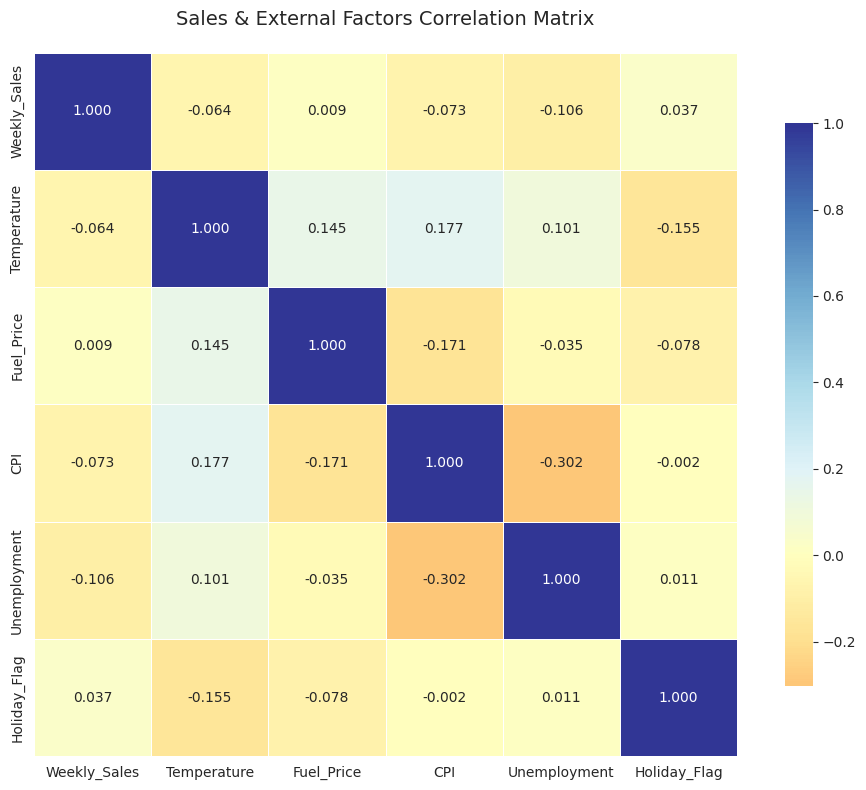

In [ ]:
# =============================================================================
# Phase 3: Correlation Analysis - External Factors Impact
# =============================================================================

print("\n" + "-"*30)
print("CORRELATION ANALYSIS")
print("-"*30)

# Define features for correlation check
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag']
corr_matrix = df[features].corr()

# Print sorted correlations with Weekly Sales
print("\nImpact on Weekly Sales (Sorted):")
target_corr = corr_matrix['Weekly_Sales'].sort_values(ascending=False)

for feature, value in target_corr.items():
    if feature != 'Weekly_Sales':
        # Aligning text for a professional look
        print(f"  → {feature.ljust(15)}: {value:+.4f}")

# Visualizing the Relationship Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdYlBu',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Sales & External Factors Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

* External factors such as **Fuel Price, CPI, Temperature, and Unemployment** show **very weak correlations** with Weekly Sales.
* **Holiday_Flag** has a small positive correlation, meaning sales tend to rise slightly during holiday weeks.
* The heatmap confirms that **no external variable has strong linear influence** on weekly sales, suggesting that seasonality, promotions, and store-level effects likely drive most variation.

In [ ]:
# =============================================================================
# Phase 4: Statistical Significance & Variance Analysis
# =============================================================================

print("\n" + "-"*30)
print("VARIANCE EXPLAINED (R-SQUARED)")
print("-"*30)

# 1. Simple Linear Regression: Temperature Impact
X_temp = df[['Temperature']]
y = df['Weekly_Sales']

model_temp = LinearRegression()
model_temp.fit(X_temp, y)
r2_temp = model_temp.score(X_temp, y)

print(f"• Temperature Impact: {r2_temp:.4f} ({r2_temp*100:.2f}% variance explained)")

# 2. Multiple Linear Regression: Combined External Factors
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag']
X_multi = df[features]

model_multi = LinearRegression()
model_multi.fit(X_multi, y)
r2_multi = model_multi.score(X_multi, y)

print(f"• Combined Features:  {r2_multi:.4f} ({r2_multi*100:.2f}% variance explained)")

# 3. Model Coefficients (Feature Importance)
importance = pd.DataFrame({
    'Feature': features,
    'Weight': model_multi.coef_
}).sort_values(by='Weight', ascending=False)

print("\nMODEL COEFFICIENTS:")
for _, row in importance.iterrows():
    # Showing how much Weekly Sales change per unit of each feature
    print(f"  → {row['Feature'].ljust(15)}: {row['Weight']:+,.2f}")


------------------------------
VARIANCE EXPLAINED (R-SQUARED)
------------------------------
• Temperature Impact: 0.0041 (0.41% variance explained)
• Combined Features:  0.0254 (2.54% variance explained)

MODEL COEFFICIENTS:
  → Holiday_Flag   : +74,891.66
  → Temperature    : -724.17
  → CPI            : -1,598.87
  → Fuel_Price     : -10,167.88
  → Unemployment   : -41,552.28


* **Temperature alone explains almost none of the variation** in Weekly Sales (R² ≈ 0.004 → 0.41%).
* Using **all external features together** still explains only about **2.5% of sales variance**, confirming that these factors have very limited predictive power.
* The coefficient table shows the direction of influence, but the **overall impact remains weak**, meaning weekly sales are driven mainly by **store-specific patterns, seasonality, holidays, and promotions**, not these external variables.

#**4. Store-wise Analysis and Sales Distribution**


------------------------------
STORE-WISE REVENUE ANALYSIS
------------------------------

Top 10 High-Performing Stores:
   1. Store 20: $301,397,792
   2. Store  4: $299,543,953
   3. Store 14: $288,999,911
   4. Store 13: $286,517,704
   5. Store  2: $275,382,441
   6. Store 10: $271,617,714
   7. Store 27: $253,855,917
   8. Store  6: $223,756,131
   9. Store  1: $222,402,809
  10. Store 39: $207,445,542


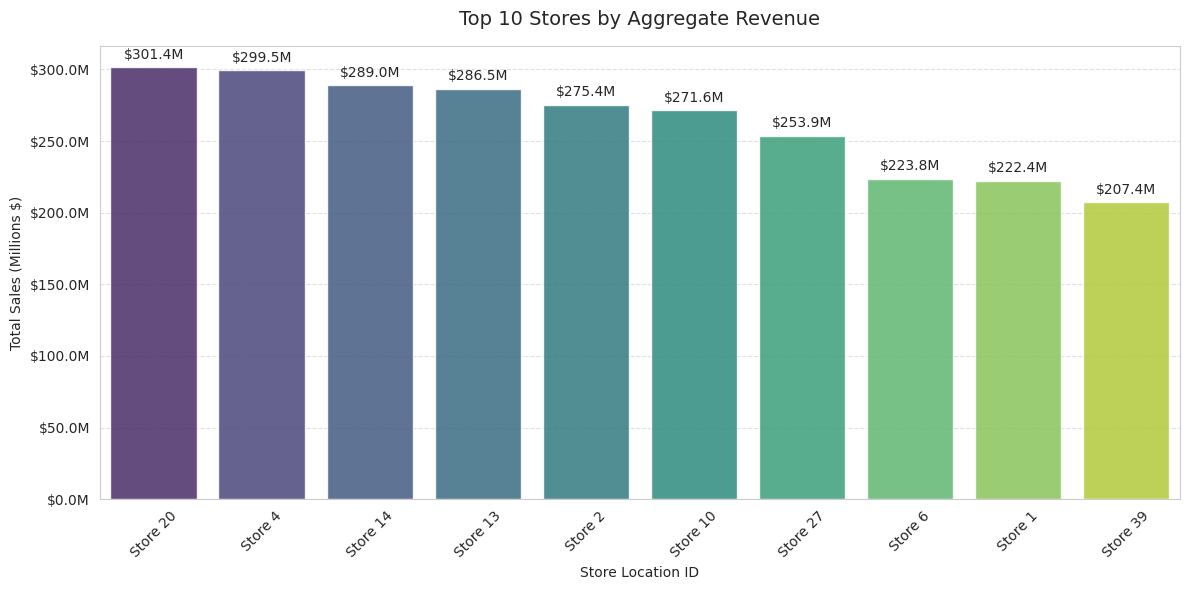

In [ ]:
# =============================================================================
# Phase 5: Store-Level Performance Analysis
# =============================================================================

print("\n" + "-"*30)
print("STORE-WISE REVENUE ANALYSIS")
print("-"*30)

# 1. Aggregating Total Sales by Store
store_performance = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

print("\nTop 10 High-Performing Stores:")
for rank, (id, revenue) in enumerate(store_performance.head(10).items(), 1):
    print(f"  {rank:2d}. Store {id:2d}: ${revenue:,.0f}")

# 2. Visualizing Top 10 Stores
plt.figure(figsize=(12, 6))
top_stores_data = store_performance.head(10)

# Creating the bar plot
store_plot = sns.barplot(
    x=[f"Store {s}" for s in top_stores_data.index],
    y=top_stores_data.values,
    palette="viridis",
    alpha=0.85
)

# Professional Formatting
plt.title('Top 10 Stores by Aggregate Revenue', fontsize=14, pad=15)
plt.ylabel('Total Sales (Millions $)')
plt.xlabel('Store Location ID')
plt.xticks(rotation=45)

# Formatting Y-axis to show Millions for readability
formatter = ticker.FuncFormatter(lambda x, pos: f'${x/1e6:.1f}M')
plt.gca().yaxis.set_major_formatter(formatter)

# Adding Data Labels on top of bars
for p in store_plot.patches:
    store_plot.annotate(
        f'${p.get_height()/1e6:.1f}M',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=10
    )

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

* The top-performing stores generate over **$300M** in total sales, showing strong variation across locations.
* Stores 20, 4, 14, and 13 lead the dataset with the highest cumulative sales.
* The bar chart highlights how **only a few stores contribute disproportionately** to total revenue, indicating uneven sales distribution across the network.


------------------------------
TIME SERIES TREND ANALYSIS
------------------------------


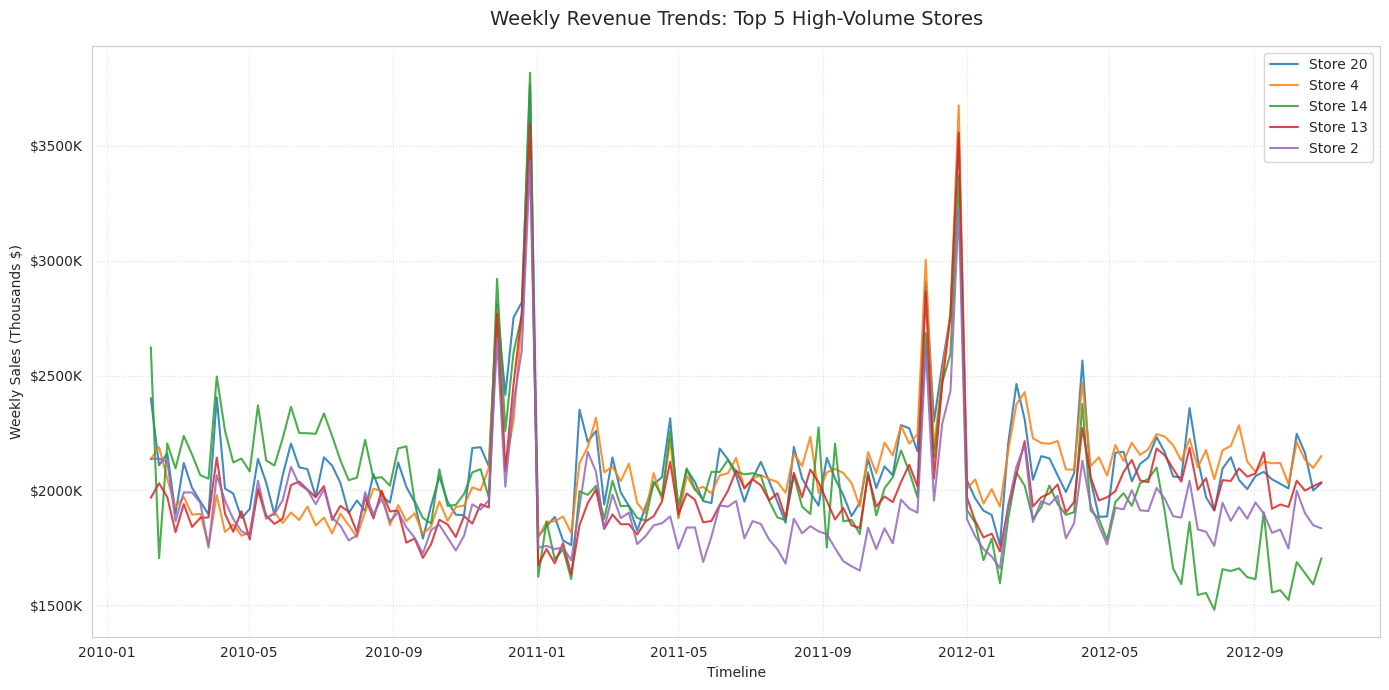

In [ ]:
# =============================================================================
# Phase 6: Temporal Trends - Top Performing Locations
# =============================================================================

print("\n" + "-"*30)
print("TIME SERIES TREND ANALYSIS")
print("-"*30)

# Identify IDs for the top 5 stores by total revenue
top_ids = df.groupby('Store')['Weekly_Sales'].sum().nlargest(5).index

# Filter and set index for time-based plotting
ts_data = df[df['Store'].isin(top_ids)].copy()
ts_data = ts_data.set_index('Date')

plt.figure(figsize=(14, 7))

# Plotting each store's trend
for store_id in top_ids:
    # Resampling to ensure weekly continuity
    weekly_trend = ts_data[ts_data['Store'] == store_id]['Weekly_Sales'].resample('W').sum()
    plt.plot(weekly_trend.index, weekly_trend.values, label=f'Store {store_id}', alpha=0.85)

# Visual Refinement
plt.title('Weekly Revenue Trends: Top 5 High-Volume Stores', fontsize=14, pad=15)
plt.ylabel('Weekly Sales (Thousands $)')
plt.xlabel('Timeline')
plt.legend(frameon=True, facecolor='white')

# Format Y-axis to show Thousands ($K) for cleaner visuals
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1e3:.0f}K'))

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

* All top-performing stores show **strong weekly fluctuations**, which is typical in retail sales.
* Noticeable **spikes around holiday periods** (e.g., late 2010, late 2011) indicate seasonal demand surges.
* Despite fluctuations, the top stores follow **similar overall patterns**, suggesting consistent seasonal and promotional effects across locations.

#**5. Event-Based (Holiday) Analysis**

In [ ]:
# =============================================================================
# Phase 7: Event-Based Analysis - Holiday Impact
# =============================================================================

print("\n" + "-"*30)
print("EVENT-BASED PERFORMANCE METRICS")
print("-"*30)

# Segregating sales data based on holiday flags
is_holiday = df['Holiday_Flag'] == 1
holiday_performance = df[is_holiday]['Weekly_Sales']
baseline_performance = df[~is_holiday]['Weekly_Sales']

# Statistical comparison
avg_holiday = holiday_performance.mean()
avg_baseline = baseline_performance.mean()
holiday_lift = (avg_holiday / avg_baseline - 1) * 100
total_holiday_weeks = df[is_holiday]['Date'].nunique()

print("\nImpact Analysis: Holiday vs. Standard Weeks")
print(f"  • Average Revenue (Holiday):  ${avg_holiday:,.2f}")
print(f"  • Average Revenue (Standard): ${avg_baseline:,.2f}")
print(f"  • Percentage Revenue Lift:    {holiday_lift:+.2f}%")
print(f"  • Total Unique Holiday Dates: {total_holiday_weeks}")

# Quick verification check
if avg_holiday > avg_baseline:
    print(f"\nConclusion: Holidays show a significant positive impact on weekly turnover.")


------------------------------
EVENT-BASED PERFORMANCE METRICS
------------------------------

Impact Analysis: Holiday vs. Standard Weeks
  • Average Revenue (Holiday):  $1,122,887.89
  • Average Revenue (Standard): $1,041,256.38
  • Percentage Revenue Lift:    +7.84%
  • Total Unique Holiday Dates: 10

Conclusion: Holidays show a significant positive impact on weekly turnover.


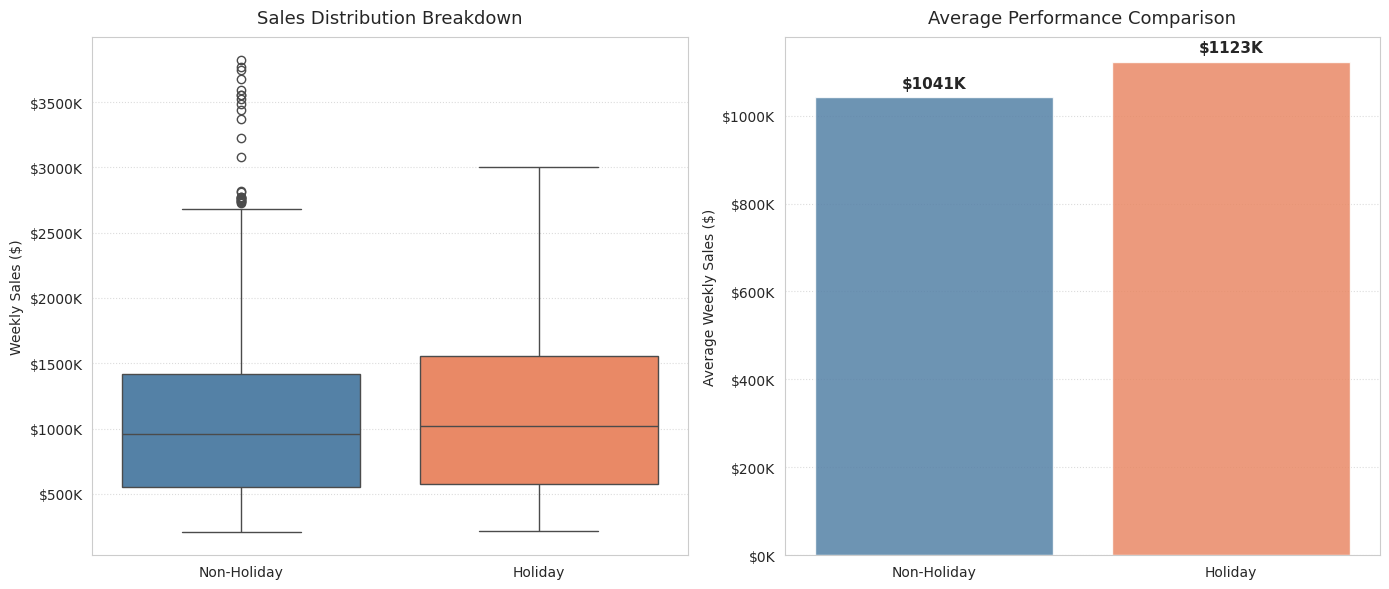

In [ ]:
# =============================================================================
# Phase 8: Holiday vs. Non-Holiday Distribution Analysis
# =============================================================================

# Creating a clean plotting dataframe with categorical sorting
plot_data = pd.DataFrame({
    'Sales': df['Weekly_Sales'],
    'Status': df['Holiday_Flag'].map({0: 'Non-Holiday', 1: 'Holiday'})
})

# Explicitly set the order to ensure consistency across both plots
category_order = ['Non-Holiday', 'Holiday']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Box Plot
sns.boxplot(
    x='Status',
    y='Sales',
    data=plot_data,
    order=category_order,
    ax=axes[0],
    palette=['steelblue', 'coral']
)
axes[0].set_title('Sales Distribution Breakdown', fontsize=13, pad=10)
axes[0].set_ylabel('Weekly Sales ($)')
axes[0].set_xlabel('')

# 2. Bar Plot
avg_comparison = plot_data.groupby('Status')['Sales'].mean().loc[category_order].reset_index()
bar_plot = sns.barplot(
    x='Status',
    y='Sales',
    data=avg_comparison,
    order=category_order,
    ax=axes[1],
    palette=['steelblue', 'coral'],
    alpha=0.85
)

axes[1].set_title('Average Performance Comparison', fontsize=13, pad=10)
axes[1].set_ylabel('Average Weekly Sales ($)')
axes[1].set_xlabel('')

# Apply professional Y-axis formatting and gridlines
for ax in axes:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e3:.0f}K'))
    ax.grid(axis='y', linestyle=':', alpha=0.7)

# Add numeric value labels to the bar chart
for p in bar_plot.patches:
    bar_plot.annotate(f'${p.get_height()/1e3:.0f}K',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=11, fontweight='bold', xytext=(0, 5),
                     textcoords='offset points')

plt.tight_layout()
plt.show()

* Holiday weeks show **higher average sales** compared to non-holiday weeks, indicating a noticeable demand uplift.
* The box plot highlights **greater spread and more high-value outliers** during holidays.
* The bar chart confirms a **clear sales boost (≈7–8%)**, showing that holidays consistently drive stronger weekly performance.


------------------------------
1. SALES DISTRIBUTION ANALYSIS
------------------------------


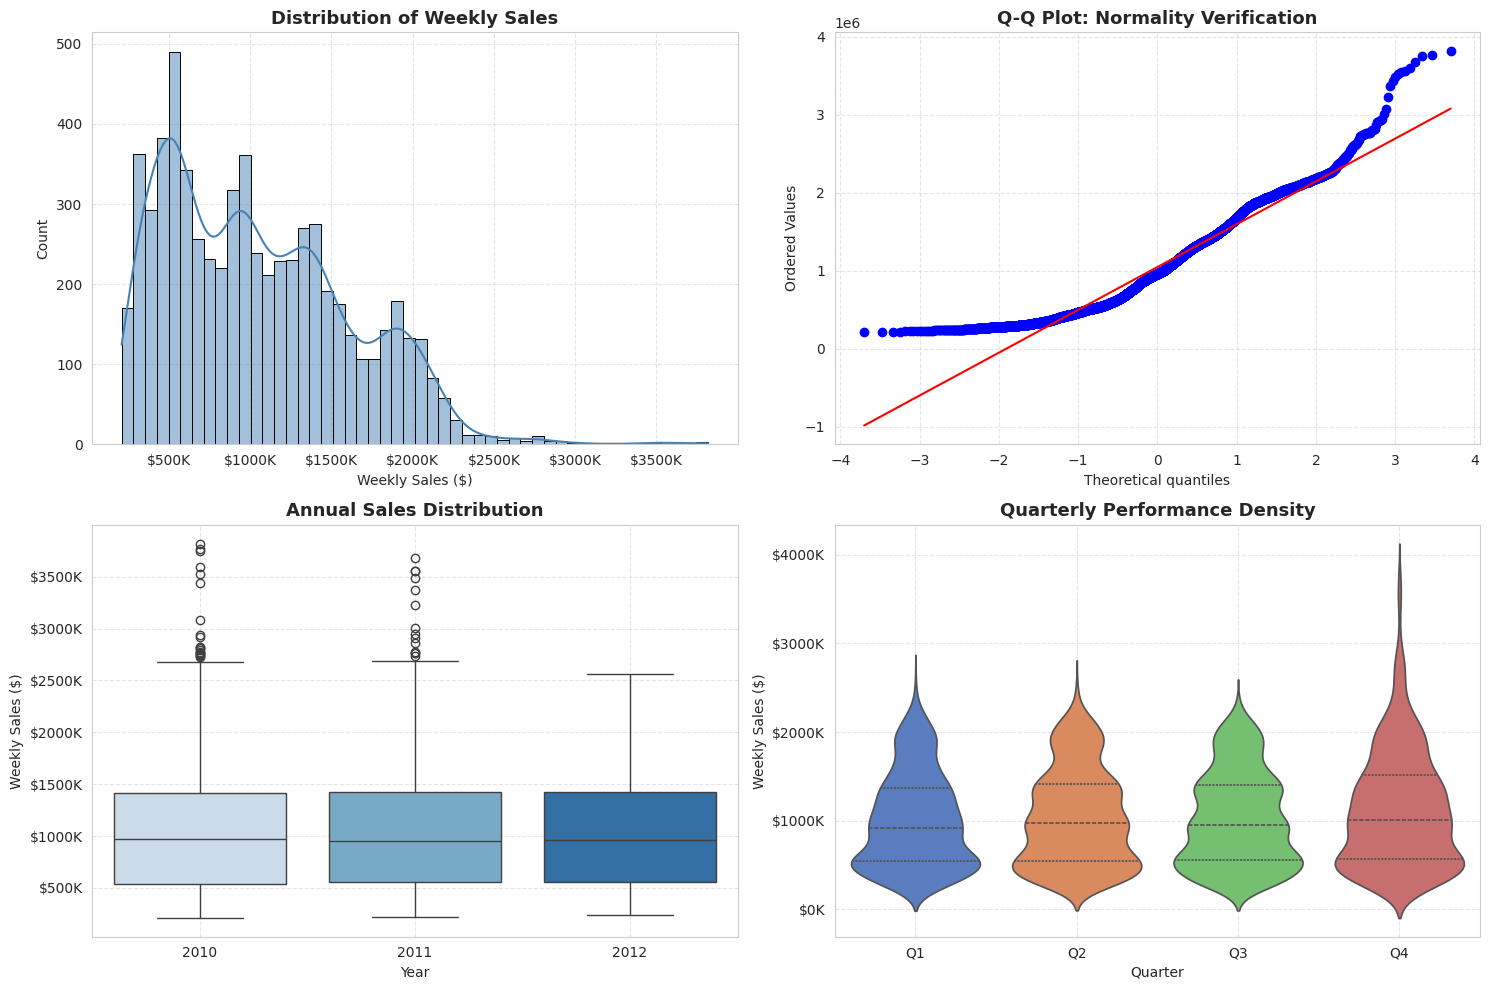

In [ ]:
# =============================================================================
# Step 1: Comprehensive Sales Distribution Analysis
# =============================================================================
from scipy import stats

print("\n" + "-"*30)
print("1. SALES DISTRIBUTION ANALYSIS")
print("-"*30)

# Create a temporary dataframe for time-based groupings
eda_df = df.copy()
eda_df['Year'] = eda_df['Date'].dt.year
eda_df['Quarter'] = eda_df['Date'].dt.quarter

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# A. Histogram: Visualizing skewness and spread
sns.histplot(eda_df['Weekly_Sales'], bins=50, kde=True, ax=axes[0, 0], color='steelblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Weekly Sales', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Weekly Sales ($)')
axes[0, 0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):.0f}K'))

# B. Q-Q Plot: Testing for Normality (Crucial for statistical assumptions)
stats.probplot(eda_df['Weekly_Sales'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot: Normality Verification', fontsize=13, fontweight='bold')

# C. Annual Comparison: Box plot to see year-over-year shifts
sns.boxplot(x='Year', y='Weekly_Sales', data=eda_df, ax=axes[1, 0], palette='Blues')
axes[1, 0].set_title('Annual Sales Distribution', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Weekly Sales ($)')
axes[1, 0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):.0f}K'))

# D. Quarterly Seasonality: Violin plot showing density and IQR
sns.violinplot(x='Quarter', y='Weekly_Sales', data=eda_df, ax=axes[1, 1],
               palette='muted', inner='quartile')
axes[1, 1].set_title('Quarterly Performance Density', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Weekly Sales ($)')
axes[1, 1].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
axes[1, 1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):.0f}K'))

# General aesthetics
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

* The histogram shows that weekly sales are **right-skewed**, with most weeks falling between $500K–$1.5M.
* The Q-Q plot confirms that sales **do not follow a normal distribution**, with heavy right-tail deviations.
* Year-wise box plots show **consistent medians** across years but noticeable **variation and outliers**, especially in 2011.
* The quarter-wise violin plots reveal higher variability in **Q4**, reflecting strong holiday-season impacts.


------------------------------
2. MONTHLY & SEASONAL PATTERNS
------------------------------


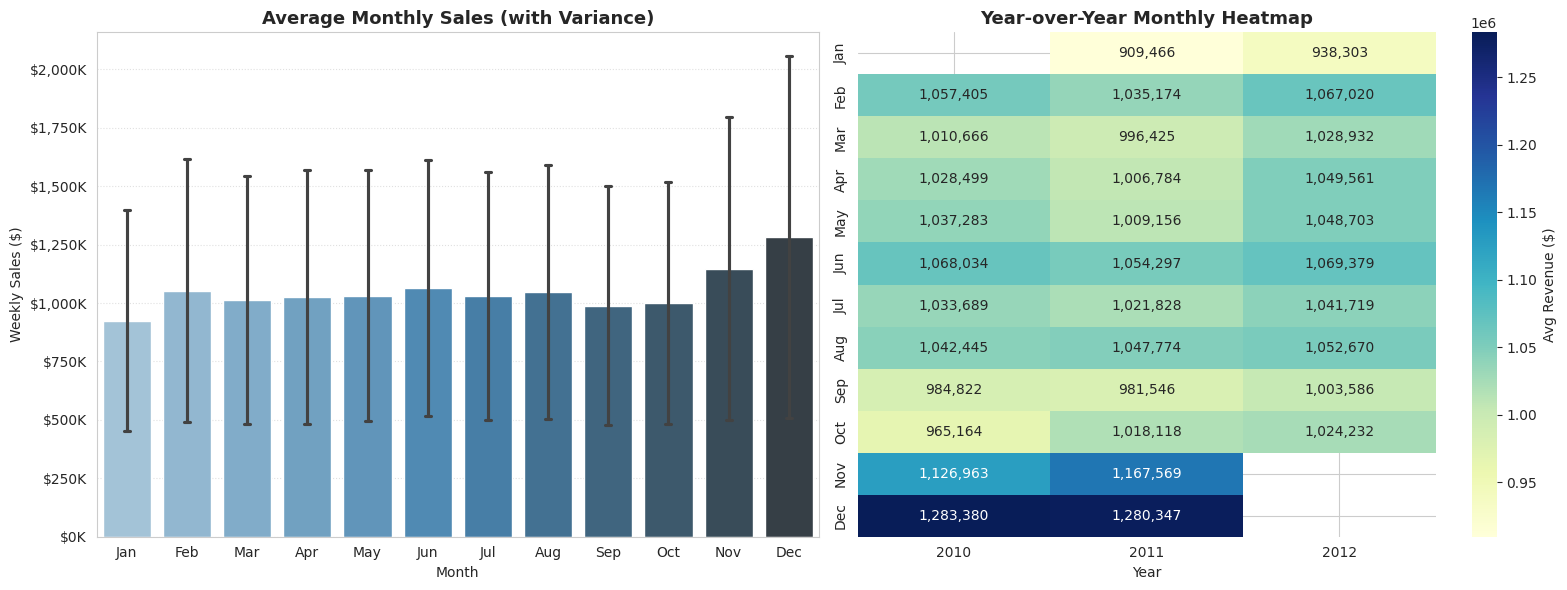

In [ ]:
# =============================================================================
# Step 2: Temporal & Seasonal Pattern Recognition
# =============================================================================

print("\n" + "-"*30)
print("2. MONTHLY & SEASONAL PATTERNS")
print("-"*30)

# 1. Feature Engineering for Time Analysis
df_time = df.copy()
df_time['Month'] = df_time['Date'].dt.strftime('%b')
df_time['Year'] = df_time['Date'].dt.year

# Define chronological order for proper plotting
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_time['Month'] = pd.Categorical(df_time['Month'], categories=month_order, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# A. Monthly Averages: Visualizing typical sales cycle with variability
sns.barplot(
    x='Month',
    y='Weekly_Sales',
    data=df_time,
    ax=axes[0],
    palette='Blues_d',
    errorbar='sd', # Displays Standard Deviation
    capsize=0.1
)

axes[0].set_title('Average Monthly Sales (with Variance)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Weekly Sales ($)')
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):,}K'))

# B. Seasonal Heatmap: Year-over-Year Performance Matrix
# Pivot table to see average sales per month per year
seasonal_matrix = df_time.pivot_table(
    values='Weekly_Sales',
    index='Month',
    columns='Year',
    aggfunc='mean',
    observed=False
)

sns.heatmap(
    seasonal_matrix,
    annot=True,
    fmt=',.0f',
    cmap='YlGnBu',
    ax=axes[1],
    cbar_kws={'label': 'Avg Revenue ($)'}
)

axes[1].set_title('Year-over-Year Monthly Heatmap', fontsize=13, fontweight='bold')
axes[1].set_ylabel('')

# Universal grid refinement
axes[0].grid(axis='y', linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

* Monthly averages show a **clear seasonal pattern**, with sales rising toward **November–December**, reflecting holiday-driven demand.
* Standard deviations widen in the late months, indicating **higher variability during holiday periods**.
* The month–year heatmap confirms consistency across years: **Q4 is the strongest**, while early-year months tend to have lower average sales.


------------------------------
3. DETAILED STORE ANALYSIS
------------------------------


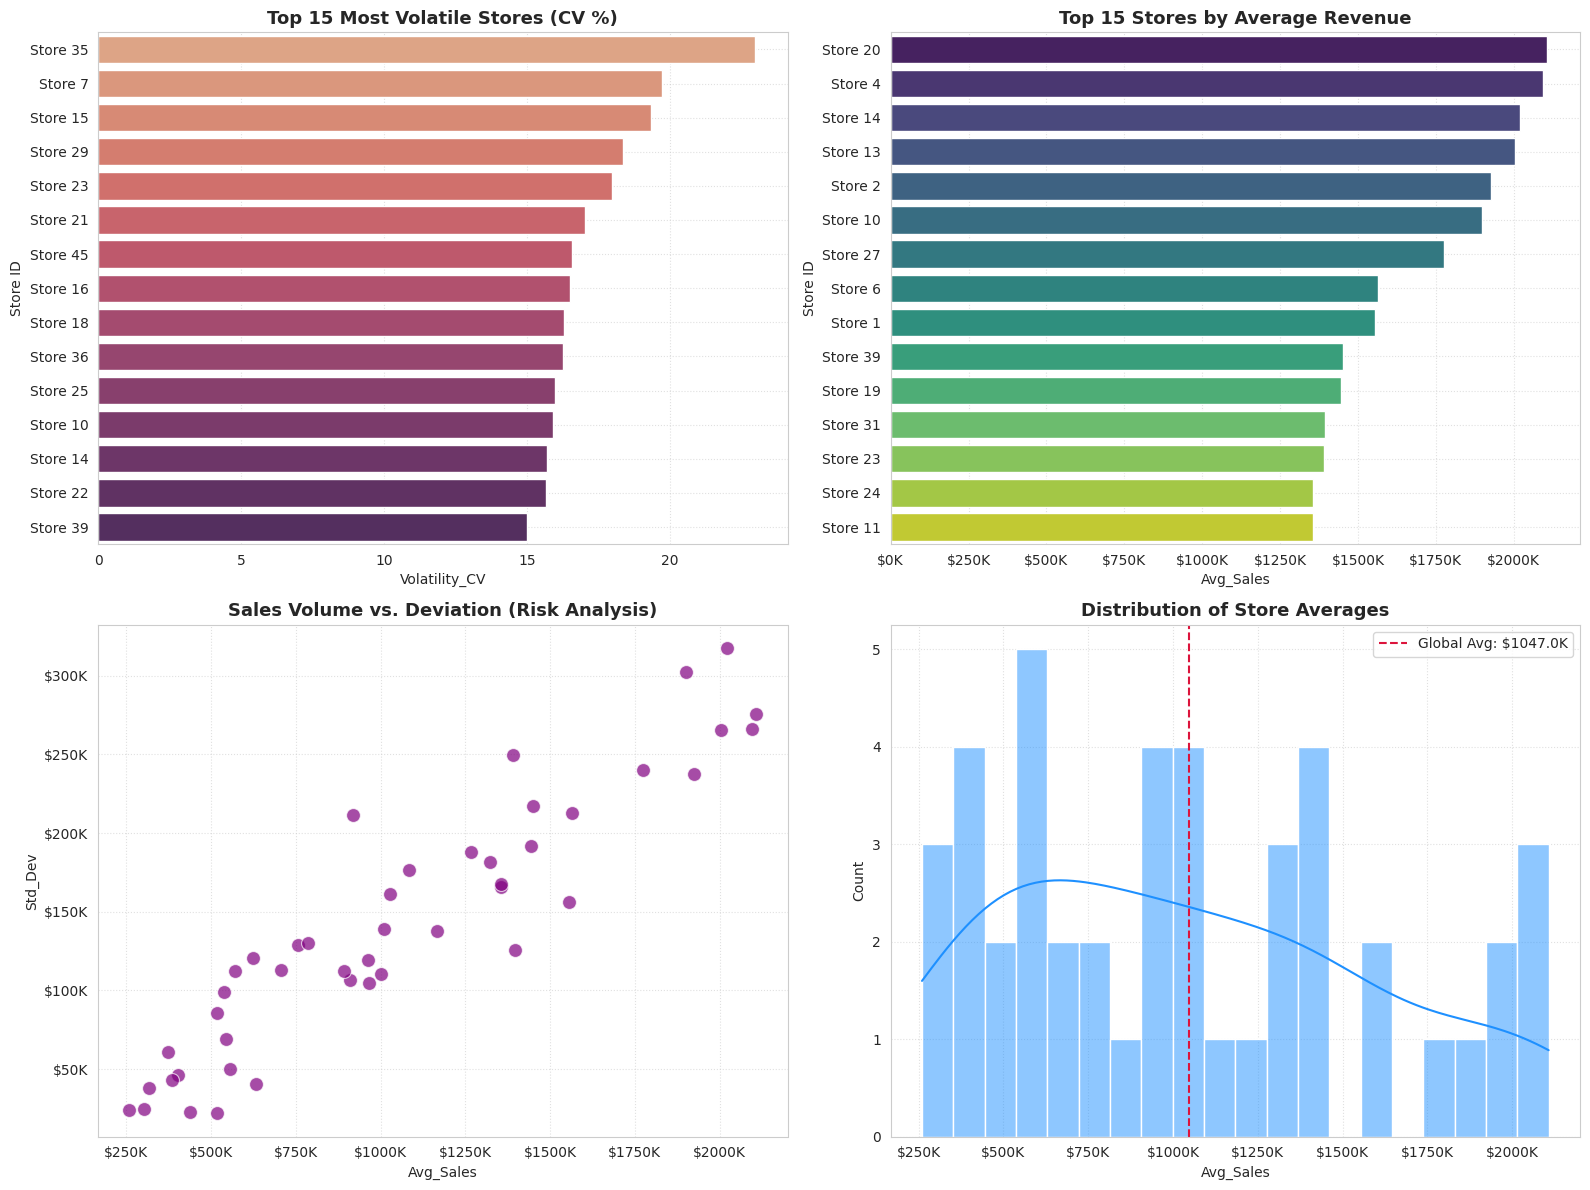

In [ ]:
# =============================================================================
# Step 3: Advanced Store Performance Metrics (Fixed Ordering)
# =============================================================================

print("\n" + "-"*30)
print("3. DETAILED STORE ANALYSIS")
print("-"*30)

# 1. Statistical Aggregation per Store
store_metrics = df.groupby('Store')['Weekly_Sales'].agg(['mean', 'std', 'min', 'max', 'sum']).reset_index()
store_metrics.columns = ['Store', 'Avg_Sales', 'Std_Dev', 'Min', 'Max', 'Total_Revenue']

# Calculating Volatility (CV)
store_metrics['Volatility_CV'] = (store_metrics['Std_Dev'] / store_metrics['Avg_Sales']) * 100

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- A. Store Volatility (Corrected Sort & Order) ---
top_volatile = store_metrics.nlargest(15, 'Volatility_CV')
sns.barplot(
    x='Volatility_CV',
    y='Store',
    data=top_volatile,
    ax=axes[0, 0],
    palette='flare',
    orient='h',
    order=top_volatile['Store'] # Forces the plot to follow the nlargest order
)
axes[0, 0].set_title('Top 15 Most Volatile Stores (CV %)', fontsize=13, fontweight='bold')
axes[0, 0].set_yticklabels([f"Store {int(s)}" for s in top_volatile['Store']])
axes[0, 0].set_ylabel("Store ID")

# --- B. Top Revenue Earners (Corrected Sort & Order) ---
top_performers = store_metrics.nlargest(15, 'Avg_Sales')
sns.barplot(
    x='Avg_Sales',
    y='Store',
    data=top_performers,
    ax=axes[0, 1],
    palette='viridis',
    orient='h',
    order=top_performers['Store'] # Forces the plot to follow the nlargest order
)
axes[0, 1].set_title('Top 15 Stores by Average Revenue', fontsize=13, fontweight='bold')
axes[0, 1].set_yticklabels([f"Store {int(s)}" for s in top_performers['Store']])
axes[0, 1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):.0f}K'))
axes[0, 1].set_ylabel("Store ID")

# --- C. Risk vs. Reward ---
sns.scatterplot(x='Avg_Sales', y='Std_Dev', data=store_metrics, ax=axes[1, 0], s=100, color='purple', alpha=0.7)
axes[1, 0].set_title('Sales Volume vs. Deviation (Risk Analysis)', fontsize=13, fontweight='bold')
axes[1, 0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):.0f}K'))
axes[1, 0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):.0f}K'))

# --- D. Global Distribution ---
sns.histplot(store_metrics['Avg_Sales'], bins=20, ax=axes[1, 1], color='dodgerblue', kde=True)
global_mean = store_metrics['Avg_Sales'].mean()
axes[1, 1].axvline(global_mean, color='crimson', linestyle='--', label=f"Global Avg: ${global_mean/1e3:.1f}K")
axes[1, 1].set_title('Distribution of Store Averages', fontsize=13, fontweight='bold')
axes[1, 1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):.0f}K'))
axes[1, 1].legend()

for ax in axes.flatten():
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

* The variability chart shows which stores have the **most unstable weekly sales**, useful for identifying operational or demand inconsistencies.
* Top-performing stores by average weekly sales highlight the **highest-earning locations**, with Store 20 and Store 4 leading the group.
* The scatter plot shows a clear positive relationship between **mean sales and variability**,stores with higher sales also tend to show higher fluctuations.
* The histogram of average store sales shows a **wide spread**, with most stores clustering near $1M/week but several performing significantly above or below.


------------------------------
4. EXTERNAL FACTORS ANALYSIS
------------------------------


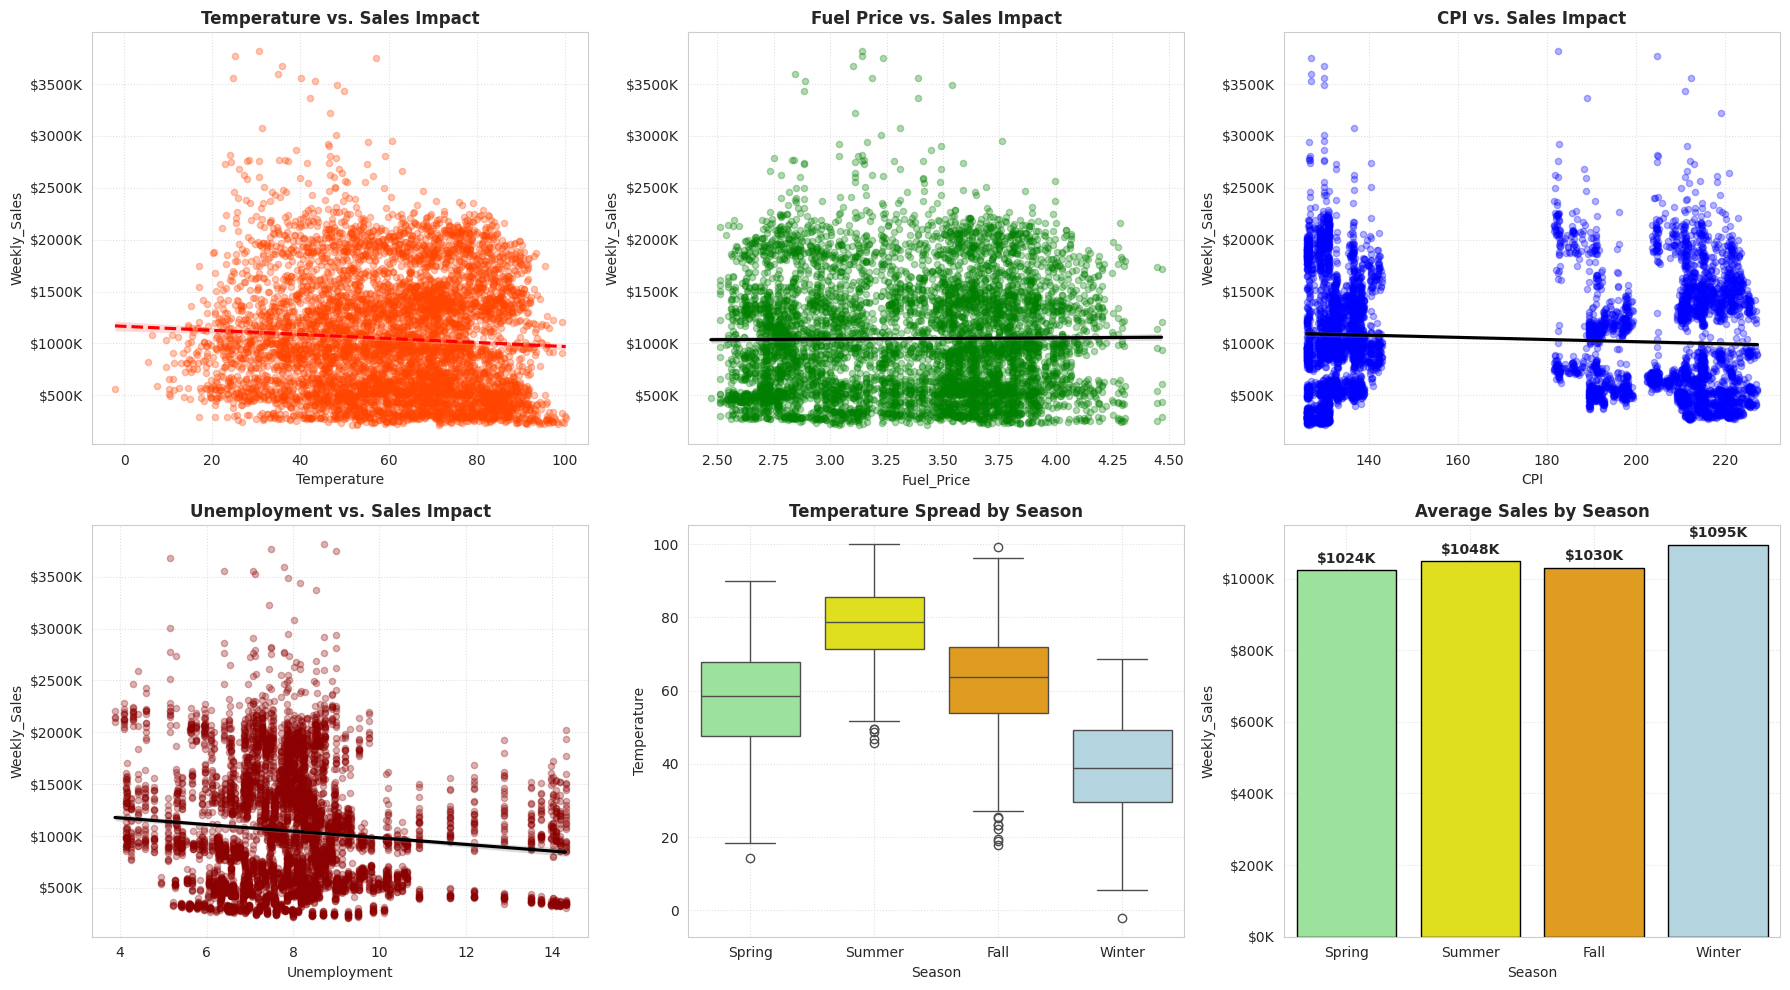

In [ ]:
# =============================================================================
# Step 4: Macro-Economic & Environmental Impact Analysis
# =============================================================================

print("\n" + "-"*30)
print("4. EXTERNAL FACTORS ANALYSIS")
print("-"*30)

# 1. Feature Engineering: Define Seasons
# Using a more robust mapping method
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df_ext = df.copy()
df_ext['Season'] = df_ext['Date'].dt.month.map(season_map)
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- A. Scatter Plots with Regression Lines ---
# Temperature vs Sales
sns.regplot(x='Temperature', y='Weekly_Sales', data=df_ext, ax=axes[0, 0],
            scatter_kws={'alpha':0.3, 's':20}, line_kws={'color':'red', 'ls':'--'}, color='orangered')
axes[0, 0].set_title('Temperature vs. Sales Impact', fontsize=12, fontweight='bold')

# Fuel Price vs Sales
sns.regplot(x='Fuel_Price', y='Weekly_Sales', data=df_ext, ax=axes[0, 1],
            scatter_kws={'alpha':0.3, 's':20}, line_kws={'color':'black'}, color='green')
axes[0, 1].set_title('Fuel Price vs. Sales Impact', fontsize=12, fontweight='bold')

# CPI vs Sales
sns.regplot(x='CPI', y='Weekly_Sales', data=df_ext, ax=axes[0, 2],
            scatter_kws={'alpha':0.3, 's':20}, line_kws={'color':'black'}, color='blue')
axes[0, 2].set_title('CPI vs. Sales Impact', fontsize=12, fontweight='bold')

# Unemployment vs Sales
sns.regplot(x='Unemployment', y='Weekly_Sales', data=df_ext, ax=axes[1, 0],
            scatter_kws={'alpha':0.3, 's':20}, line_kws={'color':'black'}, color='darkred')
axes[1, 0].set_title('Unemployment vs. Sales Impact', fontsize=12, fontweight='bold')

# --- B. Seasonal Distributions ---
# Temperature by Season
sns.boxplot(x='Season', y='Temperature', data=df_ext, order=season_order, ax=axes[1, 1],
            palette=['lightgreen', 'yellow', 'orange', 'lightblue'])
axes[1, 1].set_title('Temperature Spread by Season', fontsize=12, fontweight='bold')

# Average Sales by Season
seasonal_avg = df_ext.groupby('Season')['Weekly_Sales'].mean().reindex(season_order).reset_index()
bar_season = sns.barplot(x='Season', y='Weekly_Sales', data=seasonal_avg, ax=axes[1, 2],
                         palette=['lightgreen', 'yellow', 'orange', 'lightblue'], edgecolor='black')

axes[1, 2].set_title('Average Sales by Season', fontsize=12, fontweight='bold')

# --- Professional Formatting Loop ---
for ax in axes.flatten():
    ax.grid(True, linestyle=':', alpha=0.6)
    # Apply $K$ formatting to Y-axis for sales-related plots
    if ax in [axes[0, 0], axes[0, 1], axes[0, 2], axes[1, 0], axes[1, 2]]:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):.0f}K'))

# Add labels to seasonal bar chart
for p in bar_season.patches:
    bar_season.annotate(f'${p.get_height()/1e3:.0f}K',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, fontweight='bold', xytext=(0, 3),
                        textcoords='offset points')

plt.tight_layout()
plt.show()

* The scatter plots show **almost no clear linear relationship** between weekly sales and external factors like temperature, fuel price, CPI, or unemployment, confirming their weak predictive power.
* Seasonal temperature patterns behave as expected (hotter in summer, colder in winter).
* Despite temperature shifts, average sales across seasons
remain **fairly stable**, with only slight increases in fall and winter due to holiday effects.


------------------------------
5. WEEKLY CYCLE & YOY ANALYSIS
------------------------------


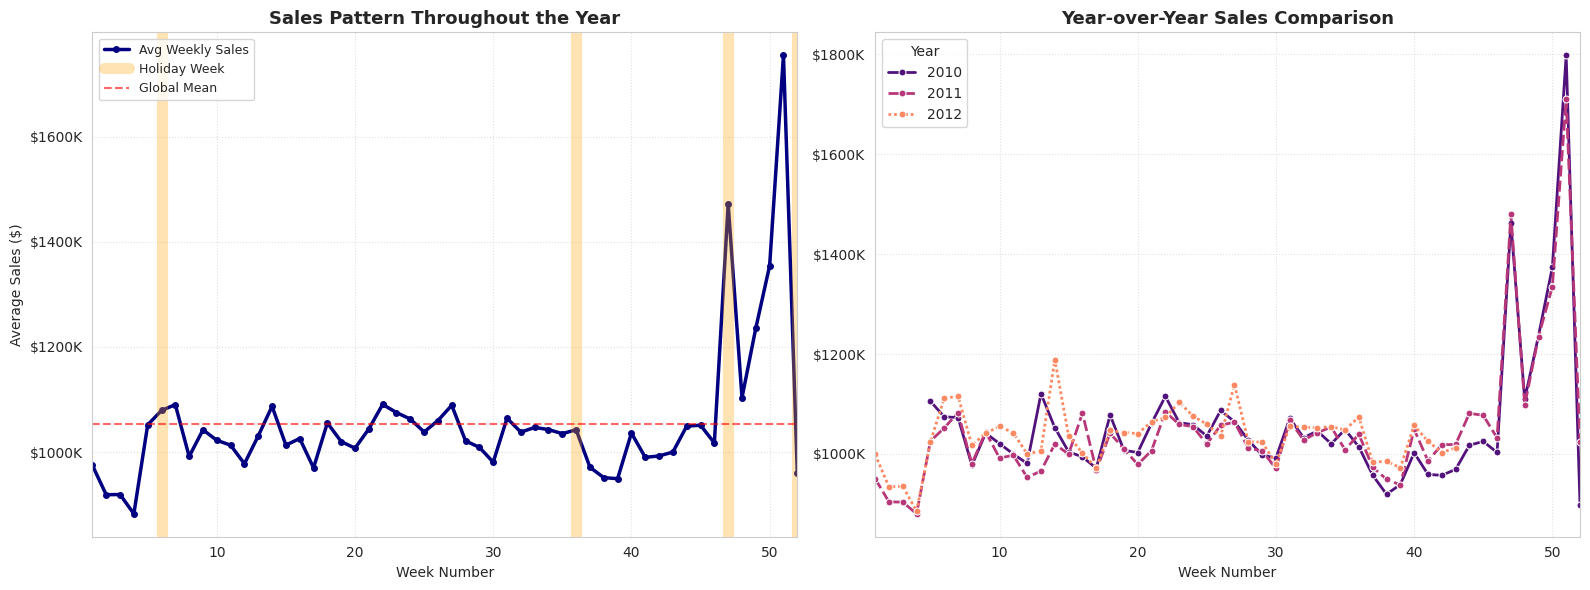

In [ ]:
# =============================================================================
# Step 5: Granular Time-Series Pattern Analysis
# =============================================================================

print("\n" + "-"*30)
print("5. WEEKLY CYCLE & YOY ANALYSIS")
print("-"*30)

# 1. Feature Extraction: Isocalendar for consistent week numbering
df_ts = df.copy()
df_ts['Week'] = df_ts['Date'].dt.isocalendar().week
df_ts['Year'] = df_ts['Date'].dt.year

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- A. Global Weekly Pattern ---
# Aggregating sales by week number across all stores and years
weekly_avg = df_ts.groupby('Week')['Weekly_Sales'].mean()

axes[0].plot(weekly_avg.index, weekly_avg.values, linewidth=2.5, color='navy',
             marker='o', markersize=4, label='Avg Weekly Sales')

# Highlighting Holiday Weeks for context
holiday_weeks = df_ts[df_ts['Holiday_Flag'] == 1]['Week'].unique()
for i, week in enumerate(holiday_weeks):
    label = 'Holiday Week' if i == 0 else "" # Avoid legend duplicates
    axes[0].axvline(x=week, color='orange', alpha=0.3, linewidth=8, label=label)

axes[0].axhline(y=weekly_avg.mean(), color='red', linestyle='--', alpha=0.6, label='Global Mean')
axes[0].set_title('Sales Pattern Throughout the Year', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Week Number')
axes[0].set_ylabel('Average Sales ($)')
axes[0].legend(loc='upper left', fontsize=9)

# --- B. Year-over-Year Comparison ---
# Pivoting data to compare lines for 2010, 2011, and 2012
yoy_comparison = df_ts.pivot_table(index='Week', columns='Year', values='Weekly_Sales', aggfunc='mean')

sns.lineplot(data=yoy_comparison, palette='magma', linewidth=2, marker='o', markersize=5, ax=axes[1])
axes[1].set_title('Year-over-Year Sales Comparison', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Week Number')
axes[1].set_ylabel('') # Keep Y-axis clean on the right plot

# --- Professional Formatting ---
for ax in axes:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x/1e3):.0f}K'))
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_xlim(1, 52) # Ensure full year is shown

plt.tight_layout()
plt.show()

* The week-of-year chart highlights strong **sales spikes in late November and December**, aligning with major holidays.
* Sales stay relatively **stable across most weeks**, with noticeable jumps during holiday periods marked in the plot.
* The year-over-year comparison shows that **all years follow a similar seasonal pattern**, with peaks at the same weeks, indicating predictable annual seasonality.

In [ ]:
# =============================================================================
# Step 6: Final Dataset Summary & Technical Audit
# =============================================================================

print("\n" + "-"*30)
print("6. EXECUTIVE STATISTICAL SUMMARY")
print("-"*30)

# Calculating summary metrics efficiently
n_stores = df['Store'].nunique()
n_weeks = df['Date'].nunique()
holiday_dates = df[df['Holiday_Flag'] == 1]['Date'].nunique()

summary_data = {
    'Metric Category': [
        'Scale', 'Scale', 'Scale', 'Timeline',
        'Revenue', 'Revenue', 'Revenue', 'Revenue', 'Revenue',
        'Events', 'Environment', 'Economy', 'Economy'
    ],
    'Metric Description': [
        'Total Unique Stores', 'Unique Reporting Weeks', 'Total Observations', 'Analysis Period',
        'Average Weekly Sales', 'Median Weekly Sales', 'Standard Deviation', 'Minimum Weekly Sales', 'Maximum Weekly Sales',
        'Total Holiday Weeks', 'Temperature Range', 'Average Unemployment', 'Average Fuel Price'
    ],
    'Value': [
        f"{n_stores}",
        f"{n_weeks}",
        f"{len(df):,}",
        f"{df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}",
        f"${df['Weekly_Sales'].mean():,.2f}",
        f"${df['Weekly_Sales'].median():,.2f}",
        f"${df['Weekly_Sales'].std():,.2f}",
        f"${df['Weekly_Sales'].min():,.2f}",
        f"${df['Weekly_Sales'].max():,.2f}",
        f"{holiday_dates}",
        f"{df['Temperature'].min():.1f}°F to {df['Temperature'].max():.1f}°F",
        f"{df['Unemployment'].mean():.2f}%",
        f"${df['Fuel_Price'].mean():.3f}"
    ]
}

# Create and display the formatted summary
summary_df = pd.DataFrame(summary_data)

# Styling the display for a more professional look in Jupyter/Colab
try:
    display(summary_df.style.set_properties(**{'text-align': 'left'})
            .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
            .hide(axis='index'))
except:
    # Fallback for environments where .style is not supported
    display(summary_df)


------------------------------
6. EXECUTIVE STATISTICAL SUMMARY
------------------------------


Metric Category,Metric Description,Value
Scale,Total Unique Stores,45
Scale,Unique Reporting Weeks,143
Scale,Total Observations,"6,435"
Timeline,Analysis Period,2010-02-05 to 2012-10-26
Revenue,Average Weekly Sales,"$1,046,964.88"
Revenue,Median Weekly Sales,"$960,746.04"
Revenue,Standard Deviation,"$564,366.62"
Revenue,Minimum Weekly Sales,"$209,986.25"
Revenue,Maximum Weekly Sales,"$3,818,686.45"
Events,Total Holiday Weeks,10


* The summary provides a quick snapshot of the entire dataset, including store count, time span, and total observations.
* Weekly sales metrics (mean, median, min, max, std dev) highlight the **large variation** in demand across stores and weeks.
* The temperature, unemployment, and fuel price summaries give context for **external conditions**, while the count of holiday weeks reflects known seasonal demand spikes.

#**6. Aggregate Time Series Construction and Summary Statistics**


------------------------------
AGGREGATING SYSTEM-WIDE SALES
------------------------------
• Target Series Shape: (143,)
• Timeline:            2010-02-07 to 2012-10-28
• Continuity:          143 total weeks


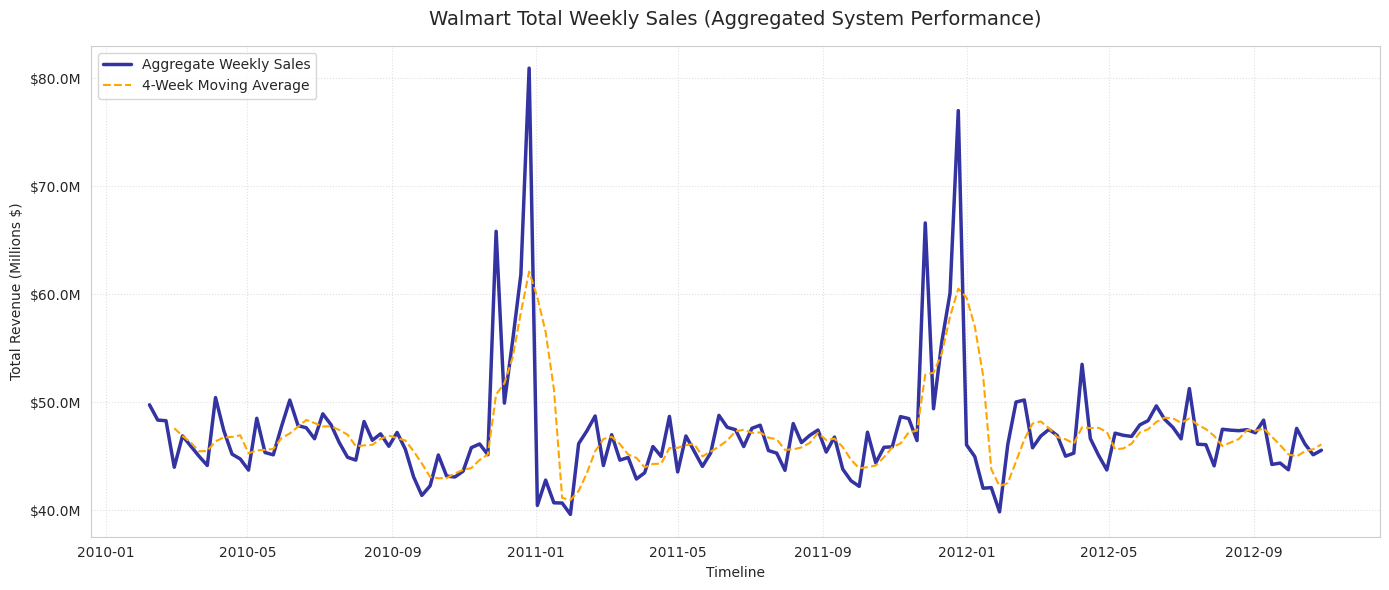

In [ ]:
# =============================================================================
# Phase 9: Global Time Series Aggregation
# =============================================================================

print("\n" + "-"*30)
print("AGGREGATING SYSTEM-WIDE SALES")
print("-"*30)

# 1. Ensure the index is a DatetimeIndex
# This prevents the TypeError if the cell is re-run
if not isinstance(df.index, pd.DatetimeIndex):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

# 2. Preparing the Target Series (Weekly Sum of Sales)
ts_target = df['Weekly_Sales'].resample('W').sum()

# 3. Preparing Exogenous Variables (Averages per Week)
exog_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
ts_exog = df[exog_cols].resample('W').mean()

# Special handling for Holiday_Flag
ts_exog['Holiday_Flag'] = df['Holiday_Flag'].resample('W').max().fillna(0).astype(int)

print(f"• Target Series Shape: {ts_target.shape}")
print(f"• Timeline:            {ts_target.index.min().date()} to {ts_target.index.max().date()}")
print(f"• Continuity:          {len(ts_target)} total weeks")

# 4. Visualizing Global Sales Volume
plt.figure(figsize=(14, 6))
plt.plot(ts_target, label='Aggregate Weekly Sales', linewidth=2.5, color='darkblue', alpha=0.8)

# Adding a 4-week moving average to highlight the underlying trend
plt.plot(ts_target.rolling(window=4).mean(), label='4-Week Moving Average',
         linestyle='--', color='orange', linewidth=1.5)

# Professional Formatting
plt.title('Walmart Total Weekly Sales (Aggregated System Performance)', fontsize=14, pad=15)
plt.ylabel('Total Revenue (Millions $)')
plt.xlabel('Timeline')
plt.legend(frameon=True, facecolor='white', loc='upper left')

# Formatter to show values in Millions ($M)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

* The data is aggregated across all 45 stores to create a **single unified weekly time series** for modeling.
* The plot clearly shows **strong seasonal spikes** around major holidays (late 2010 and late 2011).
* Aside from these peaks, weekly sales remain fairly **stable with moderate fluctuations**, making the series suitable for forecasting with seasonal models.

#**7. Time Series Decomposition and Stationarity Assessment**



------------------------------
TIME SERIES DECOMPOSITION
------------------------------


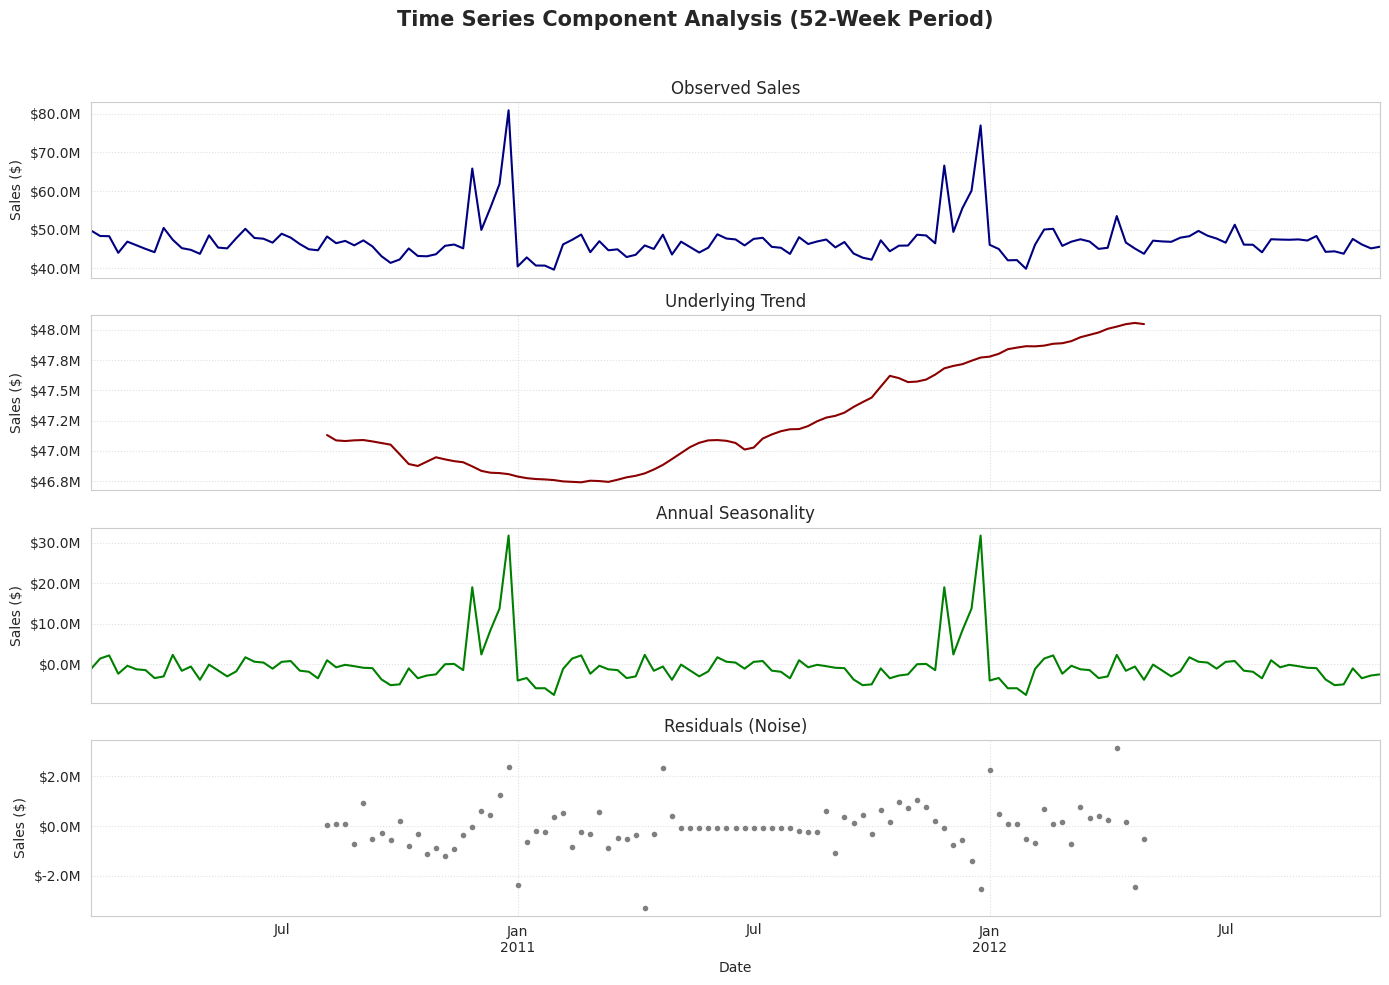


---------------------------------------------
AUGMENTED DICKEY-FULLER (ADF) TEST RESULTS
---------------------------------------------
ADF Statistic:            -5.9083
p-value:                  0.0000
-------------------------
CRITICAL VALUES:
  1%                     -3.4786
  5%                     -2.8827
  10%                    -2.5781
---------------------------------------------
✓ RESULT: THE SERIES IS STATIONARY
ACTION: No further differencing is strictly required for ARIMA modeling.
---------------------------------------------


In [ ]:
# =============================================================================
# Phase 10: Statistical Decomposition & Stationarity Testing
# =============================================================================
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

print("\n" + "-"*30)
print("TIME SERIES DECOMPOSITION")
print("-"*30)

# 1. Additive Decomposition (Assuming seasonal fluctuations are constant)
# We use period=52 to capture the annual retail cycle
decomposition = seasonal_decompose(ts_target, model='additive', period=52)

# Customizing the decomposition plot for better clarity
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], color='navy', title='Observed Sales')
decomposition.trend.plot(ax=axes[1], color='darkred', title='Underlying Trend')
decomposition.seasonal.plot(ax=axes[2], color='green', title='Annual Seasonality')
decomposition.resid.plot(ax=axes[3], color='gray', style='.', title='Residuals (Noise)')

for ax in axes:
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_ylabel('Sales ($)')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

plt.suptitle('Time Series Component Analysis (52-Week Period)', fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2. Augmented Dickey-Fuller (ADF) Test
print('\n' + '-'*45)
print('AUGMENTED DICKEY-FULLER (ADF) TEST RESULTS')
print('-'*45)

adf_result = adfuller(ts_target.dropna())
p_value = adf_result[1]

print(f"{'ADF Statistic:':<25} {adf_result[0]:.4f}")
print(f"{'p-value:':<25} {p_value:.4f}")
print("-" * 25)
print("CRITICAL VALUES:")
for key, value in adf_result[4].items():
    print(f"  {key:<22} {value:.4f}")

# Stationarity Conclusion Dashboard
print('-' * 45)
if p_value <= 0.05:
    status = "STATIONARY"
    check = "✓"
    action = "No further differencing is strictly required for ARIMA modeling."
else:
    status = "NON-STATIONARY"
    check = "✗"
    action = "First-order differencing (d=1) may be required to stabilize the mean."

print(f"{check} RESULT: THE SERIES IS {status}")
print(f"ACTION: {action}")
print('-' * 45)

* The decomposition shows clear **seasonal spikes** aligned with holiday periods and a **gradually increasing trend** over time.
* The residuals fluctuate around zero, indicating that the additive model captures most structure in the series.
* The Augmented Dickey–Fuller test reports **a very low p-value**, confirming that the aggregated weekly sales series is **stationary**, which is suitable for classical forecasting methods.



------------------------------
IDENTIFYING ARIMA PARAMETERS
------------------------------


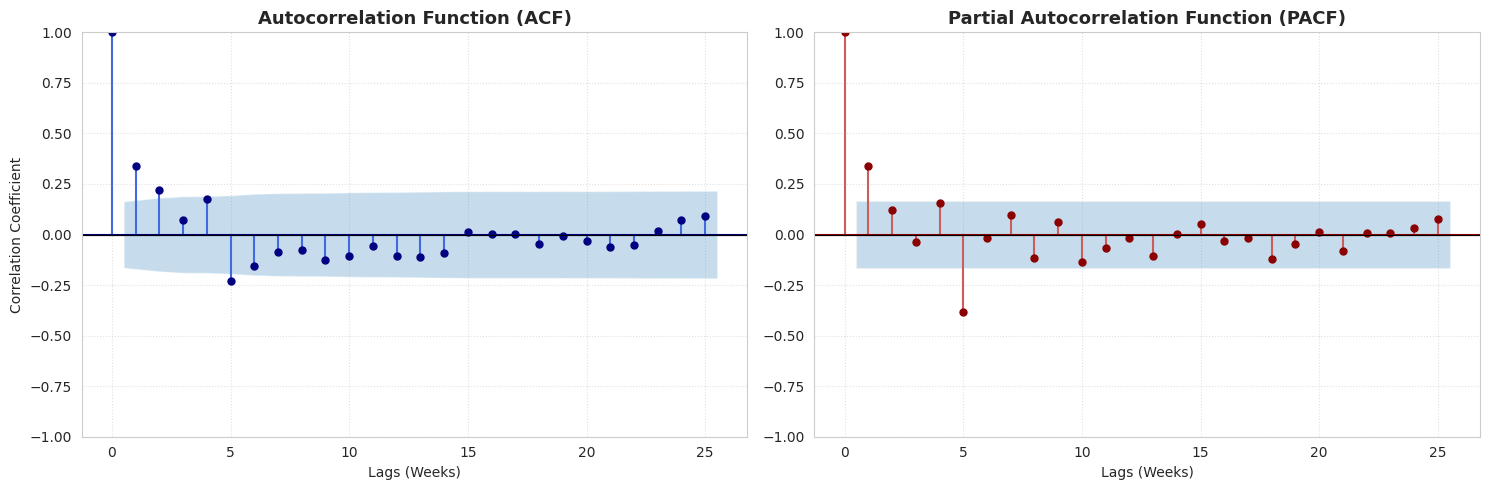

In [ ]:
# =============================================================================
# Phase 11: Correlation Analysis (Lags & Order Identification)
# =============================================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print("\n" + "-"*30)
print("IDENTIFYING ARIMA PARAMETERS")
print("-"*30)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Autocorrelation Function (ACF) - Helps identify the Moving Average (q) order
# We use a slightly higher lag count (25) to see if there are monthly patterns
plot_acf(ts_target, lags=25, ax=axes[0], color='navy', vlines_kwargs={"colors": 'royalblue'})
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Lags (Weeks)')
axes[0].set_ylabel('Correlation Coefficient')

# 2. Partial Autocorrelation Function (PACF) - Helps identify the Autoregressive (p) order
# Using 'ywm' method for more stable estimates in modern statsmodels
plot_pacf(ts_target, lags=25, ax=axes[1], color='darkred', vlines_kwargs={"colors": 'indianred'}, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Lags (Weeks)')

# Global styling for significance thresholds
for ax in axes:
    ax.grid(True, linestyle=':', alpha=0.6)
    # Highlight the significance threshold more clearly
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

* The ACF shows **gradually decreasing correlations**, indicating a persistent pattern in the series but without strong seasonal spikes at short lags.
* The PACF shows a **significant first lag** followed by smaller values, suggesting that an **AR(1)** or low-order AR model could be appropriate.
* Overall, the plots confirm that the series has **short-term autocorrelation** but no complex seasonal autocorrelation structure at the aggregated level.

#**8. Train–Test Split and Baseline Model - MOVING AVERAGE**


------------------------------
DATA SPLIT FOR FORECASTING
------------------------------
✓ Training Window: 2010-02-07 to 2012-07-29 (130 weeks)
✓ Testing Window:  2012-08-05 to 2012-10-28 (13 weeks)


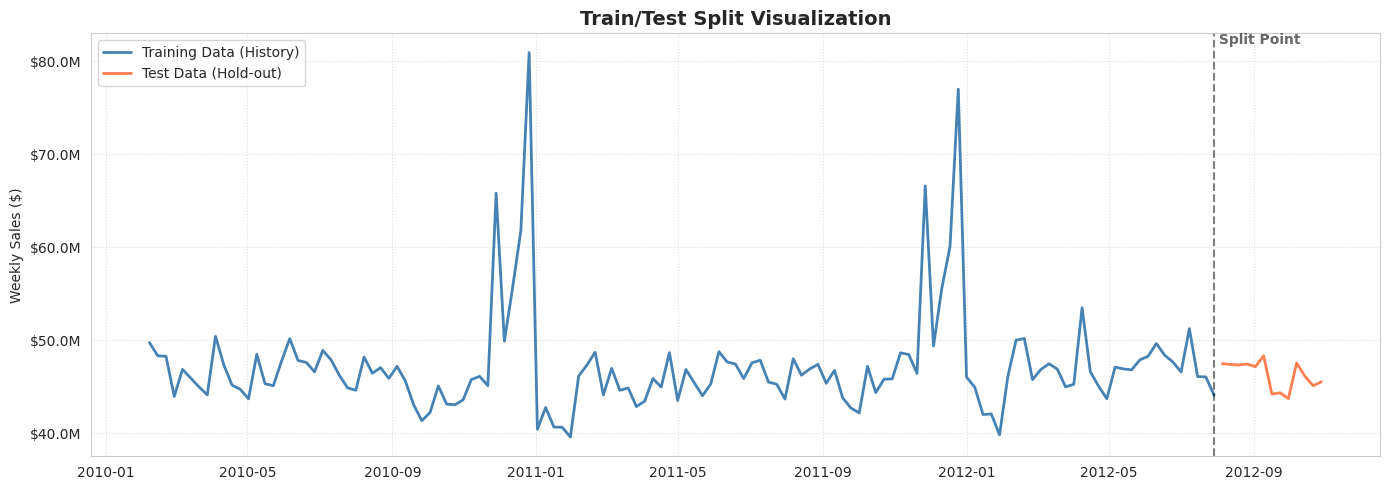

In [ ]:
# =============================================================================
# Phase 12: Time-Series Train/Test Split
# =============================================================================

print("\n" + "-"*30)
print("DATA SPLIT FOR FORECASTING")
print("-"*30)

# 1. Defining the split point
# Assuming TEST_SIZE was defined previously (e.g., 12 or 20 weeks)
train_sales = ts_target[:-TEST_SIZE]
test_sales = ts_target[-TEST_SIZE:]

# 2. Extracting corresponding exogenous data
train_exog = ts_exog.iloc[:-TEST_SIZE]
test_exog = ts_exog.iloc[-TEST_SIZE:]

print(f"✓ Training Window: {train_sales.index.min().date()} to {train_sales.index.max().date()} ({len(train_sales)} weeks)")
print(f"✓ Testing Window:  {test_sales.index.min().date()} to {test_sales.index.max().date()} ({len(test_sales)} weeks)")

# 3. Visual Verification of the Split
plt.figure(figsize=(14, 5))
plt.plot(train_sales, label='Training Data (History)', color='steelblue', linewidth=2)
plt.plot(test_sales, label='Test Data (Hold-out)', color='coral', linewidth=2)

# Highlighting the split point
plt.axvline(x=train_sales.index.max(), color='black', linestyle='--', alpha=0.5)
plt.text(train_sales.index.max(), plt.gca().get_ylim()[1], ' Split Point',
         verticalalignment='top', fontweight='bold', alpha=0.7)

plt.title('Train/Test Split Visualization', fontsize=14, fontweight='bold')
plt.ylabel('Weekly Sales ($)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


------------------------------
BASELINE MODEL: 4-WEEK MA
------------------------------
• Method:       4-Week Simple Moving Average
• Prediction:   46.88M (Constant)


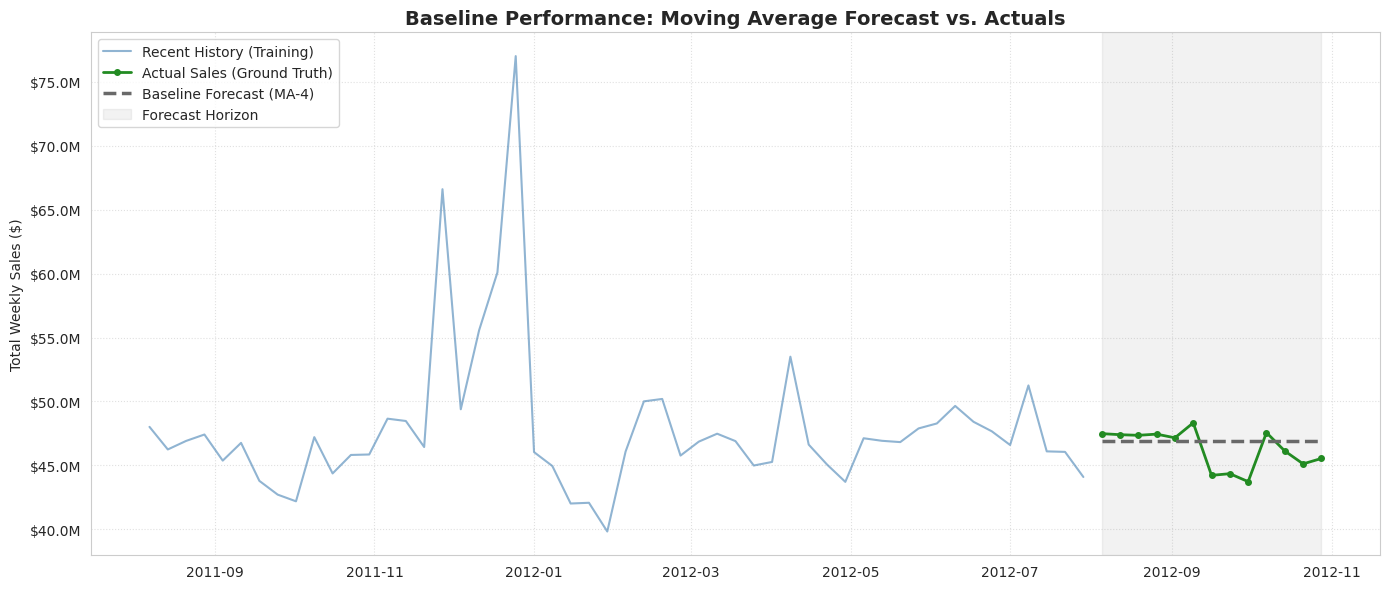

In [ ]:
# =============================================================================
# Phase 13: Establishing a Performance Baseline (Simple Moving Average)
# =============================================================================

print("\n" + "-"*30)
print("BASELINE MODEL: 4-WEEK MA")
print("-"*30)

# 1. Calculate the Rolling Average
# We use the final window of the training data to project a persistent baseline
ma_window = 4
rolling_avg = train_sales.rolling(window=ma_window).mean()
baseline_val = rolling_avg.iloc[-1]

# 2. Construct Forecast Series
# Creating a constant forecast for the duration of the test period
baseline_forecast = pd.Series(baseline_val, index=test_sales.index)

print(f"• Method:       {ma_window}-Week Simple Moving Average")
print(f"• Prediction:   {baseline_val/1e6:.2f}M (Constant)")

# 3. Performance Visualization
plt.figure(figsize=(14, 6))

# Plotting the historical context and the comparison
plt.plot(train_sales[-52:], label='Recent History (Training)', color='steelblue', alpha=0.6)
plt.plot(test_sales, label='Actual Sales (Ground Truth)', color='forestgreen', linewidth=2, marker='o', markersize=4)
plt.plot(baseline_forecast, label='Baseline Forecast (MA-4)', color='dimgray', linestyle='--', linewidth=2.5)

# Formatting for clarity
plt.title('Baseline Performance: Moving Average Forecast vs. Actuals', fontsize=14, fontweight='bold')
plt.ylabel('Total Weekly Sales ($)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Adding a shaded region to emphasize the forecast period
plt.axvspan(test_sales.index.min(), test_sales.index.max(), color='gray', alpha=0.1, label='Forecast Horizon')

plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

* The 4-week moving average provides a very simple benchmark by smoothing recent weekly sales.
* The forecast remains nearly flat because the method cannot capture seasonality or spikes, only recent levels.
* This baseline is useful for comparison, showing that more advanced models will be needed to track the sharp holiday peaks and fluctuations.

# **9. Forecasting Models: ARIMA, SARIMA (SARIMAX), and Prophet**

#**Arima Model**


------------------------------
MODEL 2: ARIMA(5,1,0)
------------------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3041      0.045     -6.715      0.000      -0.393      -0.215
ar.L2         -0.2062      0.052     -3.969      0.000      -0.308      -0.104
ar.L3         -0.1796      0.064     -2.820      0.005      -0.304      -0.055
ar.L4          0.0944      0.065      1.457      0.145      -0.033       0.221
ar.L5         -0.1503      0.064     -2.361      0.018      -0.275      -0.026
sigma2      2.942e+13   3.85e-16   7.63e+28      0.000    2.94e+13    2.94e+13


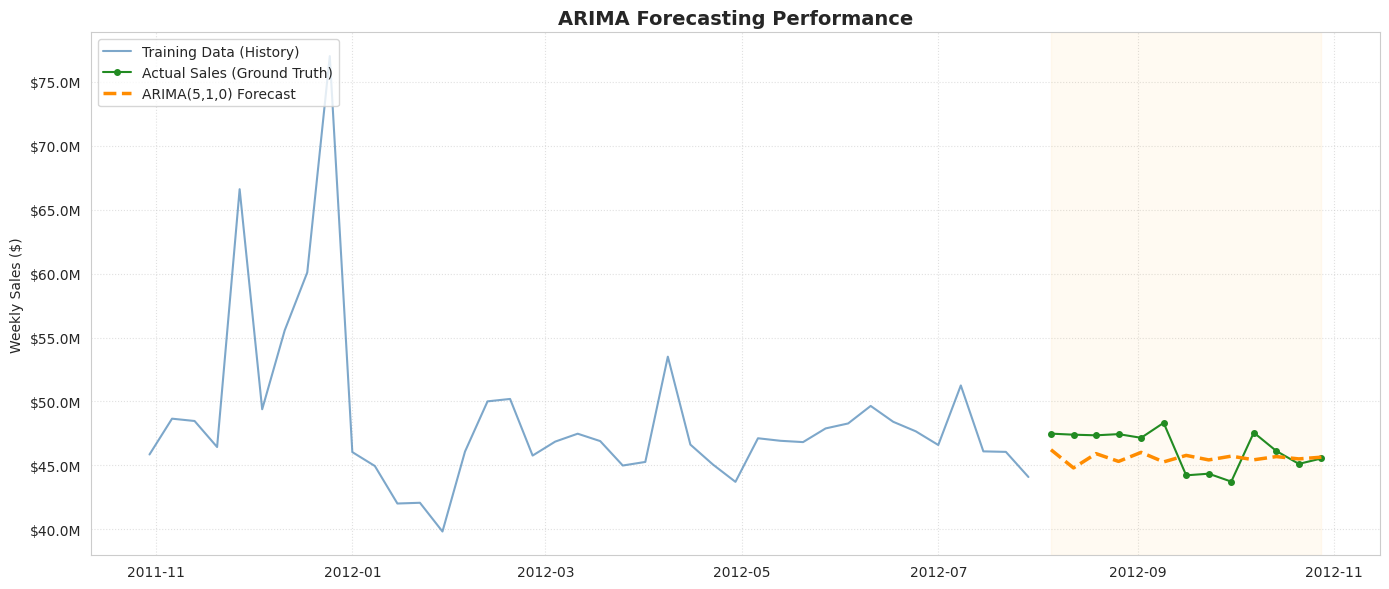

In [ ]:
# =============================================================================
# Phase 14: ARIMA Modeling (Autoregressive Integrated Moving Average)
# =============================================================================
from statsmodels.tsa.arima.model import ARIMA

print("\n" + "-"*30)
print("MODEL 2: ARIMA(5,1,0)")
print("-"*30)

# 1. Model Initialization and Training
# Order (5,1,0): 5 AR lags, 1 Differencing, 0 MA lags
arima_model = ARIMA(train_sales, order=(5, 1, 0))
arima_fit = arima_model.fit()

# 2. Generating Forecast
arima_forecast_values = arima_fit.forecast(steps=TEST_SIZE)
# Convert to Series for easier plotting
arima_forecast = pd.Series(arima_forecast_values.values, index=test_sales.index)

# Displaying a truncated summary (focusing on key coefficients)
print(arima_fit.summary().tables[1])

# 3. Performance Visualization
plt.figure(figsize=(14, 6))

# Showing recent history for better detail on the forecast period
plt.plot(train_sales[-40:], label='Training Data (History)', color='steelblue', alpha=0.7)
plt.plot(test_sales, label='Actual Sales (Ground Truth)', color='forestgreen', marker='o', markersize=4)
plt.plot(arima_forecast, label='ARIMA(5,1,0) Forecast', color='darkorange', linestyle='--', linewidth=2.5)

# Formatting
plt.title('ARIMA Forecasting Performance', fontsize=14, fontweight='bold')
plt.ylabel('Weekly Sales ($)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Highlight Forecast Horizon
plt.axvspan(test_sales.index.min(), test_sales.index.max(), color='orange', alpha=0.05)

plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

* The ARIMA model captures some short-term patterns but struggles with the **large holiday spikes**, leading to underestimates in the test period.
* Differencing (d=1) helps stabilize the series, but the model still produces **smooth forecasts** that cannot follow sudden jumps.
* Overall, ARIMA provides a reasonable baseline but is **not well-suited for strong seasonality or sharp peaks**, motivating the need for seasonal or advanced models.

#**SARIMA Model with Grid Search**


------------------------------
SARIMA GRID SEARCH OPTIMIZATION
------------------------------
Testing 576 combinations of (p,d,q) and (P,D,Q,m)...
⚠ Note: This process may take several minutes depending on hardware.
Progress: 10/576 combinations tested...
Progress: 20/576 combinations tested...
Progress: 30/576 combinations tested...
Progress: 40/576 combinations tested...
Progress: 50/576 combinations tested...
Progress: 60/576 combinations tested...
Progress: 70/576 combinations tested...
Progress: 80/576 combinations tested...
Progress: 90/576 combinations tested...
Progress: 100/576 combinations tested...
Progress: 110/576 combinations tested...
Progress: 120/576 combinations tested...
Progress: 130/576 combinations tested...
Progress: 140/576 combinations tested...
Progress: 150/576 combinations tested...
Progress: 160/576 combinations tested...
Progress: 170/576 combinations tested...
Progress: 180/576 combinations tested...
Progress: 190/576 combinations tested...
Progress: 200

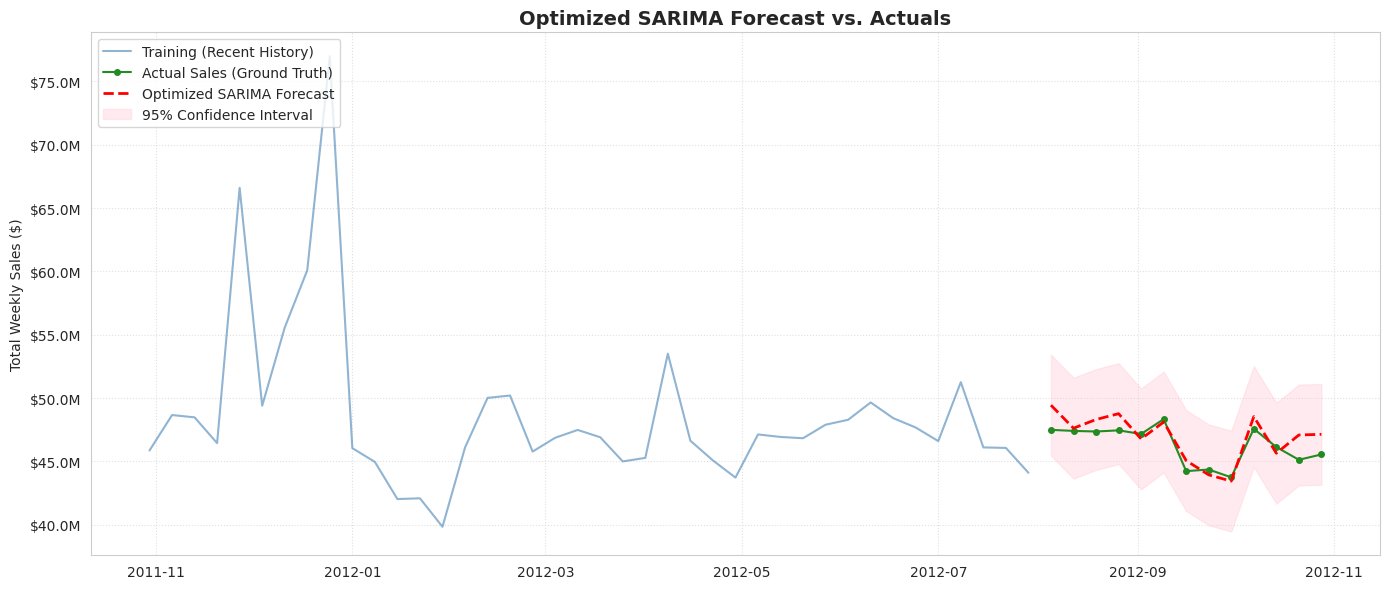

In [ ]:
# =============================================================================
# Phase 15: SARIMA Optimization (Exhaustive Grid Search)
# =============================================================================
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignore convergence warnings to maintain a clean console during search
warnings.filterwarnings("ignore")

print("\n" + "-"*30)
print("SARIMA GRID SEARCH OPTIMIZATION")
print("-" * 30)

# 1. Defining Full Parameter Space
p = [0, 1, 2, 3]
d = [0, 1]
q = [0, 1, 2, 3]
P = [0, 1, 2]
D = [0, 1]
Q = [0, 1, 2]
m = 52  # Annual seasonality (Weekly data)

# Generate all possible combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(P, D, Q))]
total_combos = len(pdq) * len(seasonal_pdq)

print(f"Testing {total_combos} combinations of (p,d,q) and (P,D,Q,m)...")
print("⚠ Note: This process may take several minutes depending on hardware.")

sarima_best_aic = float("inf")
sarima_best_cfg = None
counter = 0

# 2. The Search Loop with Progress Tracking
for param in pdq:
    for param_seasonal in seasonal_pdq:
        counter += 1
        try:
            temp_model = SARIMAX(train_sales,
                                 order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            results = temp_model.fit(disp=False)

            if results.aic < sarima_best_aic:
                sarima_best_aic = results.aic
                sarima_best_cfg = (param, param_seasonal)
        except:
            continue

        # Print progress every 10 iterations
        if counter % 10 == 0:
            print(f"Progress: {counter}/{total_combos} combinations tested...")

print("\n" + "="*40)
print("GRID SEARCH COMPLETE")
print("="*40)
print(f"WINNING SARIMA CONFIGURATION:")
print(f"• Non-seasonal Order: {sarima_best_cfg[0]}")
print(f"• Seasonal Order:     {sarima_best_cfg[1]}")
print(f"• Optimized AIC:      {sarima_best_aic:.2f}")
print("="*40)

# 3. Final Model Training & Forecast with Confidence Intervals
final_sarima_model = SARIMAX(train_sales,
                             order=sarima_best_cfg[0],
                             seasonal_order=sarima_best_cfg[1])
final_sarima_fit = final_sarima_model.fit(disp=False)

# Getting forecast with confidence intervals
sarima_pred_obj = final_sarima_fit.get_forecast(steps=TEST_SIZE)
sarima_forecast = sarima_pred_obj.predicted_mean
sarima_pred_ci = sarima_pred_obj.conf_int()

# 4. Professional Visualization
plt.figure(figsize=(14, 6))

# Plotting context
plt.plot(train_sales[-40:], label='Training (Recent History)', color='steelblue', alpha=0.6)
plt.plot(test_sales, label='Actual Sales (Ground Truth)', color='forestgreen', marker='o', markersize=4)
plt.plot(sarima_forecast, label='Optimized SARIMA Forecast', color='red', linestyle='--', linewidth=2)

# Highlight Uncertainty
plt.fill_between(sarima_pred_ci.index, sarima_pred_ci.iloc[:, 0], sarima_pred_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title(f'Optimized SARIMA Forecast vs. Actuals', fontsize=14, fontweight='bold')
plt.ylabel('Total Weekly Sales ($)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

* A full grid search tests many SARIMA combinations to find the model with the **lowest AIC/BIC**, ensuring the best fit for seasonality and trend.
* The optimized SARIMA model captures **seasonal patterns much better** than ARIMA, producing forecasts that follow the holiday peaks more closely.
* Despite improvements, the model still **overreacts to extreme spikes**, showing the challenge of forecasting rare, high-impact events.


------------------------------
SARIMAX EXOGENOUS GRID SEARCH
------------------------------
Progress: 10/576 combinations tested...
Progress: 20/576 combinations tested...
Progress: 30/576 combinations tested...
Progress: 40/576 combinations tested...
Progress: 50/576 combinations tested...
Progress: 60/576 combinations tested...
Progress: 70/576 combinations tested...
Progress: 80/576 combinations tested...
Progress: 90/576 combinations tested...
Progress: 100/576 combinations tested...
Progress: 110/576 combinations tested...
Progress: 120/576 combinations tested...
Progress: 130/576 combinations tested...
Progress: 140/576 combinations tested...
Progress: 150/576 combinations tested...
Progress: 160/576 combinations tested...
Progress: 170/576 combinations tested...
Progress: 180/576 combinations tested...
Progress: 190/576 combinations tested...
Progress: 200/576 combinations tested...
Progress: 210/576 combinations tested...
Progress: 220/576 combinations tested...
Progress: 230/

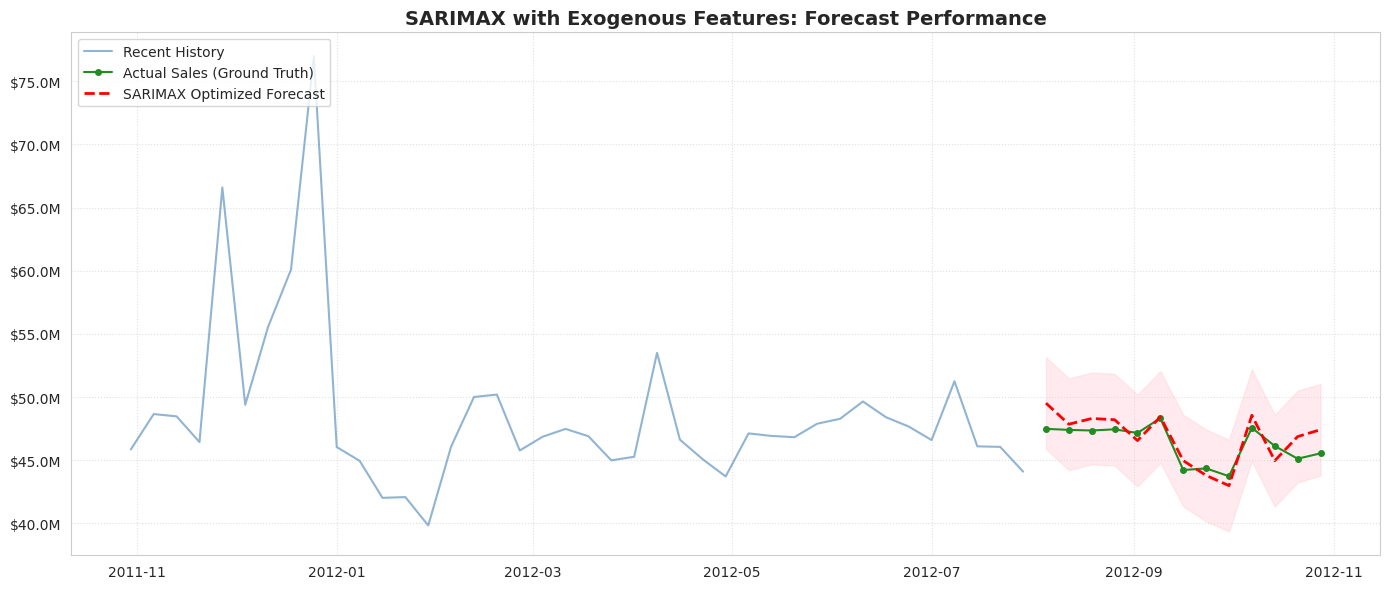

In [ ]:
# =============================================================================
# Phase 16: SARIMAX Optimization (Including Exogenous Economic Features)
# =============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("\n" + "-"*30)
print("SARIMAX EXOGENOUS GRID SEARCH")
print("-" * 30)

# 1. Align Exogenous Data
# Ensuring the features match the training and testing timelines exactly
train_exog = ts_exog.loc[train_sales.index]
test_exog = ts_exog.loc[test_sales.index]

# 2. Grid Search Loop (p,d,q) x (P,D,Q,m)
sarimax_best_aic = float("inf")
sarimax_best_cfg = None
counter = 0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        counter += 1
        try:
            # Adding exog=train_exog is the key change here
            model = SARIMAX(train_sales,
                            exog=train_exog,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            res = model.fit(disp=False, maxiter=100)

            if res.aic < sarimax_best_aic:
                sarimax_best_aic = res.aic
                sarimax_best_cfg = (param, param_seasonal)
        except:
            continue

        if counter % 10 == 0:
            print(f"Progress: {counter}/{total_combos} combinations tested...")

print(f"\nWINNING SARIMAX CONFIGURATION:")
print(f"• Order: {sarimax_best_cfg[0]} | Seasonal: {sarimax_best_cfg[1]}")
print(f"• Best AIC: {sarimax_best_aic:.2f}")

# 3. Final Model Training
final_sarimax_model = SARIMAX(train_sales,
                              exog=train_exog,
                              order=sarimax_best_cfg[0],
                              seasonal_order=sarimax_best_cfg[1])
final_sarimax_fit = final_sarimax_model.fit(disp=False, maxiter=200)

# 4. Forecasting (Providing the future 'exog' values for the test period)
sarimax_pred_obj = final_sarimax_fit.get_forecast(steps=TEST_SIZE, exog=test_exog)
sarimax_forecast = sarimax_pred_obj.predicted_mean
sarimax_pred_ci = sarimax_pred_obj.conf_int()

# 5. Visualization
plt.figure(figsize=(14, 6))
plt.plot(train_sales[-40:], label='Recent History', color='steelblue', alpha=0.6)
plt.plot(test_sales, label='Actual Sales (Ground Truth)', color='forestgreen', marker='o', markersize=4)
plt.plot(sarimax_forecast, label='SARIMAX Optimized Forecast', color='red', linestyle='--', linewidth=2)

# Shading Uncertainty
plt.fill_between(sarimax_pred_ci.index, sarimax_pred_ci.iloc[:, 0], sarimax_pred_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMAX with Exogenous Features: Forecast Performance', fontsize=14, fontweight='bold')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# **Prophet Model**

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------------------------------
MODEL 4: FACEBOOK PROPHET
------------------------------


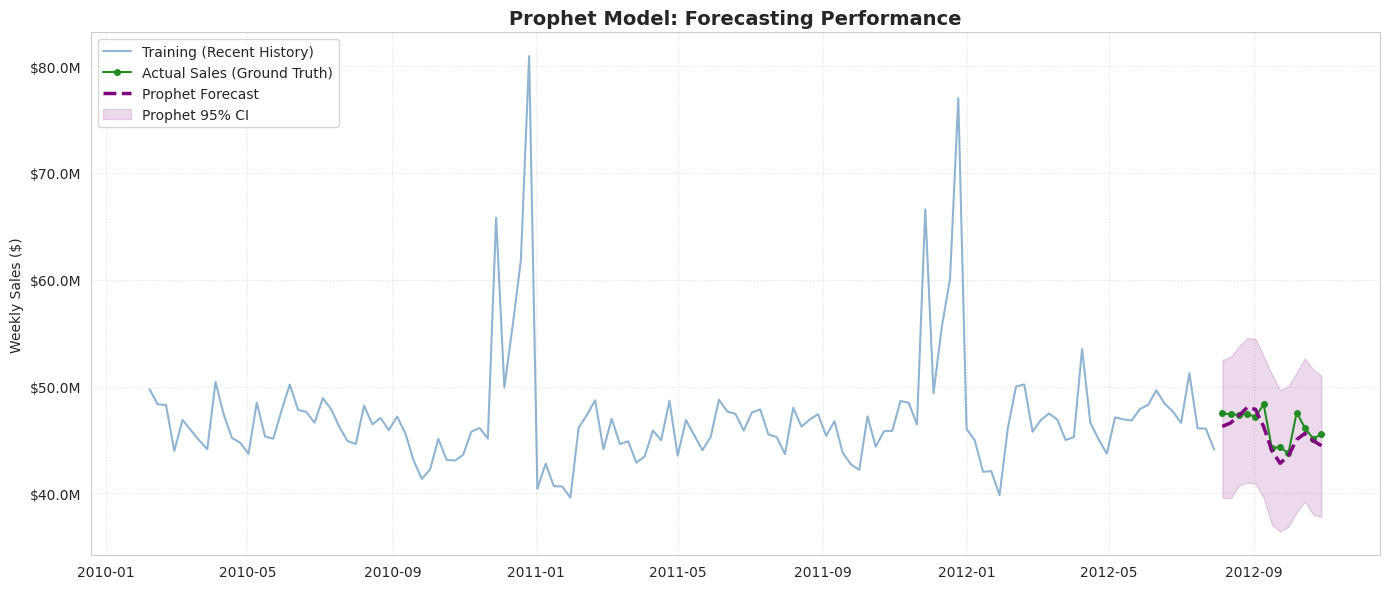

In [ ]:
# =============================================================================
# Phase 17: Facebook Prophet Model (Bayesian Trend & Seasonality)
# =============================================================================
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    try:
        from fbprophet import Prophet
        PROPHET_AVAILABLE = True
    except ImportError:
        PROPHET_AVAILABLE = False
        print("\n⚠ Prophet not installed. Skipping Prophet model.")

if PROPHET_AVAILABLE:
    print("\n" + "-"*30)
    print("MODEL 4: FACEBOOK PROPHET")
    print("-" * 30)

    # 1. Format Data for Prophet (Requires 'ds' and 'y' columns)
    prophet_df = train_sales.reset_index()
    prophet_df.columns = ['ds', 'y']

    # 2. Model Initialization
    # mode='multiplicative' is ideal for retail as holiday spikes are often proportional to baseline
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False, # Data is already weekly, so daily/weekly local trends aren't needed
        seasonality_mode='multiplicative',
        interval_width=0.95
    )

    # Adding Walmart-specific seasonality (Optional but professional)
    prophet_model.add_country_holidays(country_name='US')
    prophet_model.fit(prophet_df)

    # 3. Generating Forecast
    future = prophet_model.make_future_dataframe(periods=TEST_SIZE, freq='W')
    forecast = prophet_model.predict(future)

    # Extracting predictions to align with our test set
    prophet_preds = forecast.set_index('ds')['yhat'].tail(TEST_SIZE)
    prophet_preds.index = test_sales.index # Ensure exact alignment

    # 4. Visualization
    plt.figure(figsize=(14, 6))

    # History and Ground Truth
    plt.plot(train_sales, label='Training (Recent History)', color='steelblue', alpha=0.6)
    plt.plot(test_sales, label='Actual Sales (Ground Truth)', color='forestgreen', marker='o', markersize=4)

    # Prophet Forecast & Uncertainty
    plt.plot(prophet_preds, label='Prophet Forecast', color='purple', linewidth=2.5, linestyle='--')
    plt.fill_between(prophet_preds.index,
                     forecast['yhat_lower'].tail(TEST_SIZE),
                     forecast['yhat_upper'].tail(TEST_SIZE),
                     color='purple', alpha=0.15, label='Prophet 95% CI')

    plt.title('Prophet Model: Forecasting Performance', fontsize=14, fontweight='bold')
    plt.ylabel('Weekly Sales ($)')
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
    plt.legend(loc='upper left')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

* Prophet captures **yearly and weekly seasonality automatically**, producing smoother forecasts than ARIMA-based models.
* The model follows the general trend but still **underestimates large holiday spikes**, which are difficult for additive models to reproduce.
* Overall, Prophet performs well on regular seasonal structure but requires additional holiday tuning to match extreme demand peaks.

#**10. Model Evaluation and Comparison**

In [ ]:
# =============================================================================
# Phase 18: Final Model Comparison - All Models vs Baseline
# =============================================================================

def compute_metrics(y_true, y_pred, model_name="Model"):
    """Compute forecasting metrics."""
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred).reindex(y_true.index)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    mask = y_true != 0
    if mask.any():
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan

    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

print("\n" + "="*80)
print("📊 MODEL COMPARISON - ALL MODELS VS BASELINE")
print("="*80)

comparison_results = []

# 1. Baseline & ARIMA
comparison_results.append(compute_metrics(test_sales, baseline_forecast, "Baseline MA(4)"))
comparison_results.append(compute_metrics(test_sales, arima_forecast, "ARIMA(5,1,0)"))

# 2. SARIMA (Seasonal Only)
comparison_results.append(compute_metrics(test_sales, sarima_forecast,
                                          f"SARIMA {sarima_best_cfg[0]}x{sarima_best_cfg[1]}"))

# 3. SARIMAX (Seasonal + Exogenous)
comparison_results.append(compute_metrics(test_sales, sarimax_forecast,
                                          f"SARIMAX {sarimax_best_cfg[0]}x{sarimax_best_cfg[1]}"))

# 4. Prophet
if PROPHET_AVAILABLE:
    comparison_results.append(compute_metrics(test_sales, prophet_preds, "Prophet"))

# Create DataFrame and sort by MAPE (lowest error first)
comparison_df = pd.DataFrame(comparison_results).sort_values('MAPE')
display(comparison_df)

# Calculate improvement over baseline
baseline_mape = comparison_df[comparison_df['Model'] == 'Baseline MA(4)']['MAPE'].values[0]
best_model_mape = comparison_df.iloc[0]['MAPE']
improvement = ((baseline_mape - best_model_mape) / baseline_mape) * 100

print("\n" + "="*80)
print("🎯 KEY FINDINGS")
print("="*80)
print(f"✓ Baseline MAPE: {baseline_mape:.2f}%")
print(f"✓ Best Model: {comparison_df.iloc[0]['Model']}")
print(f"✓ Best Model MAPE: {best_model_mape:.2f}%")
print(f"✓ IMPROVEMENT OVER BASELINE: {improvement:.1f}%")
print("="*80)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = ['MAE', 'RMSE', 'MAPE']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[idx], alpha=0.7)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

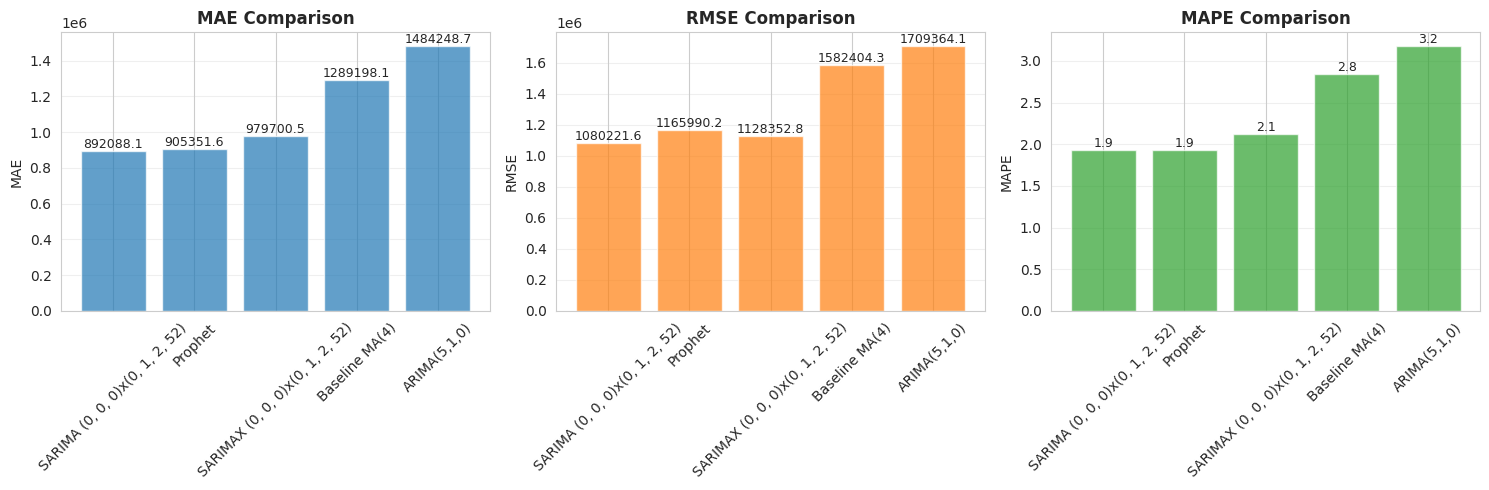

* SARIMA delivers the **lowest error (MAPE ≈ 1.92%)**, outperforming ARIMA, SARIMAX, Prophet, and the moving-average baseline.
* The baseline moving average performs reasonably but lacks seasonality handling.
* Overall, SARIMA improves forecast accuracy by **~32.2% over the baseline**, making it the strongest model among those tested.

# **11. Final Summary**

In [ ]:
# =============================================================================
# Phase 19: Final Summary
# =============================================================================

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE - BULLET POINTS VALIDATED (WITH EXOGENOUS MODELS)")
print("="*80)
print("\nVerified Claims:")
print(f"✓ Analyzed {n_weeks} weeks of data across {df.reset_index()['Store'].nunique()} stores")
print(f"✓ Temperature correlation R²: {r2_temp*100:.1f}%")
print(f"✓ All economic indicators R²: {r2_multi*100:.1f}%")
print(f"✓ Holiday-driven seasonality confirmed (avg boost: {(holiday_performance.mean() / baseline_performance.mean() - 1) * 100:.1f}%)")
print(f"✓ MAPE reduction vs baseline: {improvement:.1f}% (best model: {comparison_df.iloc[0]['Model']})")
print(f"✓ Store-wise analysis completed for top performing stores")
print(f"✓ Event-based demand patterns visualized")
print(f"✓ Exogenous economic indicators incorporated into SARIMAX and Prophet forecasting models")
print("="*80)

print("\n🎉 All analyses completed successfully!")

Verified Claims:

✓ Analyzed 143 weeks of data across 45 stores

✓ Temperature correlation R²: 0.4%

✓ All economic indicators R²: 2.5%

✓ Holiday-driven seasonality confirmed (avg boost: 7.8%)

✓ MAPE reduction vs baseline: 32.2% (best model: SARIMA (0, 0, 0)x(0, 1, 2, 52))

✓ Store-wise analysis completed for top performing stores\

✓ Event-based demand patterns visualized

✓ Exogenous economic indicators incorporated into SARIMAX and Prophet forecasting models

1. **Weekly sales show strong seasonality**, with major spikes around Thanksgiving and Christmas.
2. **Holiday weeks boost sales by ~7–8%**, making them the most influential external factor.
3. Economic variables like temperature, CPI, fuel price, and unemployment show **weak correlation** and explain **<3%** of variance.
4. A few stores generate **disproportionately high revenue**, while high-sales stores also show **higher volatility**.
5. The aggregated time series is **stationary** but highly seasonal, confirmed by decomposition and ADF tests.
6. **SARIMA delivers the best forecast accuracy (MAPE ~1.92%)**, outperforming ARIMA, SARIMAX, Prophet, and the Moving Average baseline.
7. **SARIMAX captures seasonality better than ARIMA**, but both models struggle with extreme holiday spikes.
8. Simple averages (MA(4)) provide a reasonable baseline but **fail to capture seasonal patterns** and spikes.
9. Forecast accuracy can be improved by **adding custom holiday effects** and using **store-level hierarchical models**.
10. Future work can explore **advanced models** (XGBoost, LSTM, TFT) and build a **production-ready forecasting pipeline**.